# Statistical analysis

## Setup

In [1]:
%matplotlib inline

In [310]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




In [311]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments.csv')  
experiments = experiments.fillna('-')


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [312]:
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-


### effect size methods

In [313]:
def omega_squared(ms_effect, ms_error, df_effect, ss_total):
    return (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)

In [314]:
def omega_squared_partial(ms_effect, ms_error, df_effect, total_observations):
    return (df_effect * (ms_effect - ms_error)) / ((total_observations - df_effect) * ms_error)

In [315]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [316]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [317]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [318]:
def ci(m, num_observations, ms_error):
    t = stats.t.ppf(1-0.025, num_observations)
    return t*math.sqrt(ms_error/num_observations)

In [319]:
experiments.head()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-


## Is the LM baseline improved by accuracy-oriented changes?

### Select LambdaMart data

In [320]:
lambdata = experiments[experiments.ranker == 'lambdamart']
lambdata['fm_yes_no'] = (lambdata.feature_method != '-')
lambdata = lambdata.reset_index(drop=True)
lambdata

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,fm_yes_no
0,0.21168,1.96463,1.43316,1.68645,1.32943,0.04198,0.08750,3462,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,True
1,1.07183,2.17346,0.99640,1.90473,1.32943,0.10384,0.08791,8940,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,True
2,0.69834,3.45495,1.98301,1.53864,1.31771,0.06697,0.17542,10795,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,True
3,0.80910,1.65976,0.75591,1.46067,1.32943,0.01519,0.08762,12073,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,True
4,0.24675,2.39058,1.93819,2.07945,1.33332,0.01797,0.00548,12096,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.71886,3.09551,1.74605,1.76113,1.33327,0.00656,0.01141,64062,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,False
2276,0.01131,2.15078,1.99585,0.52595,1.08236,0.66969,0.72625,66637,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,False
2277,0.01039,1.77589,1.73610,0.59773,1.08333,0.63429,0.70164,67404,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,False
2278,0.52623,1.54197,0.97068,1.75083,1.31769,0.17458,0.17828,70673,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,False


### ANOVA of all main factors vs EEL

We only have one replication per cell so we can't look at interactions.

In [321]:
formula = "difference ~ C(augmentation) + C(fm_yes_no) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,2.12716,1.06358,3.58619,0.02786
C(fm_yes_no),1.00000,0.00323,0.00323,0.01089,0.91690
C(val_metric),1.00000,2.14902,2.14902,7.24609,0.00716
C(qid),19.00000,421.60145,22.18955,74.81888,0.00000
Residual,2256.00000,669.07742,0.29658,NaN,NaN


The influence of augmentation (p = 0.02786 < 0.05) and val_metric (p = 0.00716 < 0.05) and qid (p = 0.00000 < 0.05) are significant

#### ANOVA effect sizes

In [322]:
ss_effect = anova_lm(lm).sum_sq.loc['C(augmentation)']
ss_error = anova_lm(lm).sum_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()

print(f"eta-squared augmentation\teta-squared partial augmentation")
print(f"{eta_squared(ss_effect, ss_total)}\t\t\t\t{eta_squared_partial(ss_effect, ss_error)}")

eta-squared augmentation	eta-squared partial augmentation
0.00194				0.00317


In [323]:
ss_effect = anova_lm(lm).sum_sq.loc['C(val_metric)']
ss_error = anova_lm(lm).sum_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()

print(f"eta-squared val_metric\teta-squared partial val_metric")
print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")

eta-squared val_metric	eta-squared partial val_metric
0.00196			0.0032


The effect sizes are small :)

#### Tukey HSD

In [324]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0645 0.1651 -0.0188 0.1478  False
     - aug0.7   0.0651 0.1598 -0.0183 0.1484  False
aug0.5 aug0.7   0.0006    0.9 -0.0828 0.0839  False
---------------------------------------------------


In [325]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   err   ndcg  -0.0614 0.0344 -0.1183 -0.0045   True
----------------------------------------------------


#### cohen's d

In [326]:
lambdata.groupby('augmentation')['difference'].mean()

augmentation
-        0.83253
aug0.5   0.89703
aug0.7   0.89762
Name: difference, dtype: float64

In [327]:
# augmentation
means = lambdata.groupby('augmentation')['difference'].mean()
m_none = means['-']
m_07 = means['aug0.7']
m_05 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m_none, m_07, ms_error))
print(cohens_d(m_none, m_05, ms_error))
print(cohens_d(m_05, m_07, ms_error))


0.11951519688328394
0.1184354032636047
0.001079793619679234


In [328]:
# val_metric
means = lambdata.groupby('val_metric')['difference'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.11274946260608576


ALL the effects are small!

#### Visualize performance in term of difference, disparity, relevance + bar charts

In [329]:
lambdata.groupby('augmentation')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
augmentation,,,
-,0.83253,2.19424,1.22745
aug0.5,0.89703,2.10873,1.15245
aug0.7,0.89762,2.11332,1.15445


In [330]:
lambdata.groupby('val_metric')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
val_metric,,,
err,0.90643,2.21543,1.20110
ndcg,0.84503,2.06209,1.15513


The base config of LambdaMart performs best in terms of group difference.

<AxesSubplot:xlabel='augmentation', ylabel='relevance'>

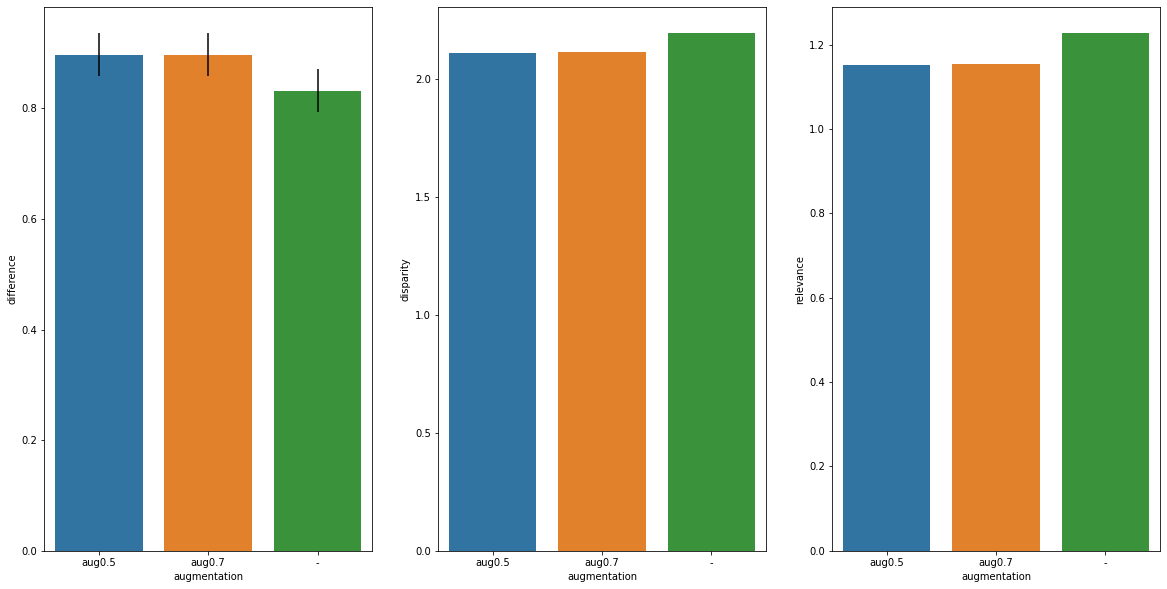

In [331]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('augmentation')
means = groups['difference'].mean()
m1 = means['aug0.5']
n1 = len(groups.get_group('aug0.5'))
m2 = means['aug0.7']
n2 = len(groups.get_group('aug0.7'))
m3 = means['-']
n3 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='augmentation', y='difference',ci=None, yerr=[c1,c2,c3], data=lambdata,ax=axs[0])
sns.barplot(x='augmentation', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='augmentation', y='relevance', ci=None, data=lambdata, ax=axs[2])


<AxesSubplot:xlabel='val_metric', ylabel='relevance'>

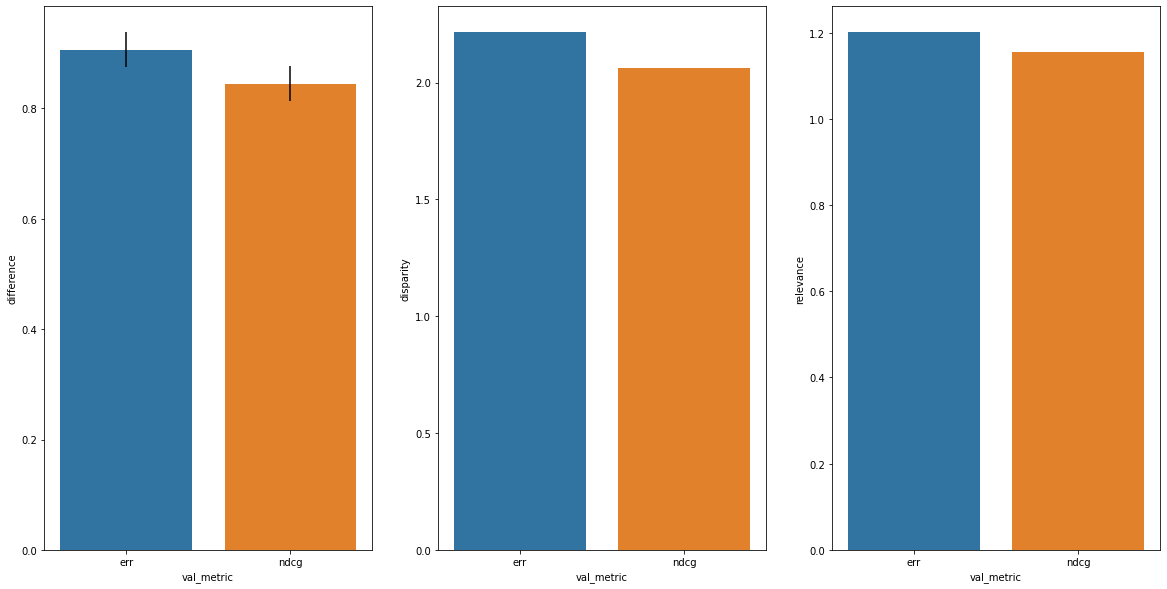

In [332]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

ymax = groups[['difference','disparity','relevance']].mean().max().max() + 0.2
fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='val_metric', y='difference',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance', ci=None, data=lambdata, ax=axs[2])

<AxesSubplot:xlabel='fm_yes_no', ylabel='relevance'>

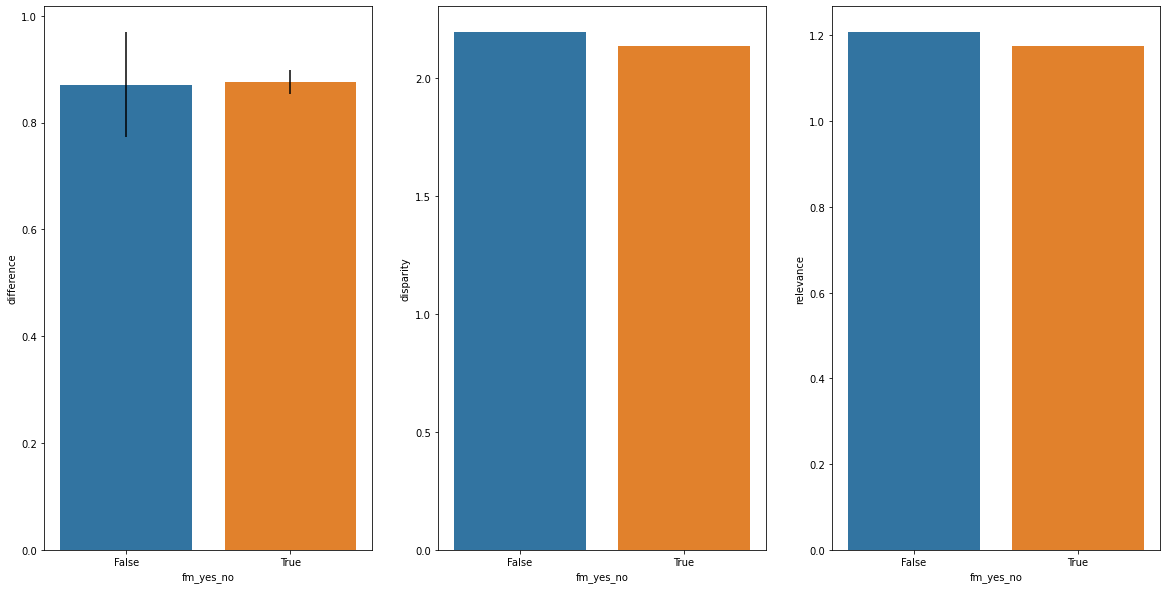

In [333]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('fm_yes_no')
means = groups['difference'].mean()
m1 = means[False]
n1 = len(groups.get_group(False))
m2 = means[True]
n2 = len(groups.get_group(True))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='fm_yes_no', y='difference',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='fm_yes_no', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='fm_yes_no', y='relevance', ci=None, data=lambdata, ax=axs[2])

### ANOVA of all main factors vs EEL_ind

We only have one replication per cell so we can't look at interactions.

In [334]:
def full_eval_run(ivs, dv, data):
    ivs_for_formula = [f'C({iv})' for iv in ivs]
    formula = f"{dv} ~ {' + '.join(ivs_for_formula)}"
    lm = ols(formula, data).fit()
    anova = anova_lm(lm)
    print(anova)
    

In [335]:
formula = "difference_ind ~ C(augmentation) + C(fm_yes_no) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.78448,0.89224,6.65212,0.00132
C(fm_yes_no),1.00000,1.48403,1.48403,11.06424,0.00089
C(val_metric),1.00000,4.21711,4.21711,31.44082,0.00000
C(qid),19.00000,172.06359,9.05598,67.51725,0.00000
Residual,2256.00000,302.59359,0.13413,NaN,NaN


#### ANOVA effect sizes

In [336]:
def print_etasq(factor):
    ss_effect = anova_lm(lm).sum_sq.loc[f'C({factor})']
    ss_error = anova_lm(lm).sum_sq.loc['Residual']
    ss_total = anova_lm(lm).sum_sq.sum()

    print(factor)
    print(f"eta-squared\teta-squared partial")
    print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")
    print()

In [337]:
print_etasq('augmentation')
print_etasq('val_metric')
print_etasq('fm_yes_no')
print_etasq('qid')

augmentation
eta-squared	eta-squared partial
0.0037			0.00586

val_metric
eta-squared	eta-squared partial
0.00875			0.01374

fm_yes_no
eta-squared	eta-squared partial
0.00308			0.00488

qid
eta-squared	eta-squared partial
0.35687			0.3625



#### Tukey HSD

In [338]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0165 0.7424 -0.0387 0.0718  False
     - aug0.7   0.0659 0.0145  0.0106 0.1211   True
aug0.5 aug0.7   0.0493 0.0913 -0.0059 0.1046  False
---------------------------------------------------


In [339]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['fm_yes_no'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 False   True  -0.1143 0.0081 -0.1987 -0.0298   True
----------------------------------------------------


In [340]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   err   ndcg   -0.086 0.001 -0.1236 -0.0484   True
---------------------------------------------------


In [345]:
print(len(experiments))
len(experiments.drop_duplicates())

67280


67280

#### cohen's d

In [346]:
means = lambdata.groupby('augmentation')['difference_ind'].mean()
means

augmentation
-        1.41906
aug0.5   1.43558
aug0.7   1.48492
Name: difference_ind, dtype: float64

In [347]:
# augmentation
means = lambdata.groupby('augmentation')['difference_ind'].mean()
m1 = means['-']
m2 = means['aug0.7']
m3 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


0.179821829458751
0.04511761759520932
0.1347042118635417


In [348]:
# feature_method
means = lambdata.groupby('fm_yes_no')['difference_ind'].mean()
m1 = means[True]
m2 = means[False]
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.3119684765614529


In [349]:
# val_metric
means = lambdata.groupby('val_metric')['difference_ind'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.23486023311051413


ALL the effects are small!

#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='augmentation', ylabel='relevance_ind'>

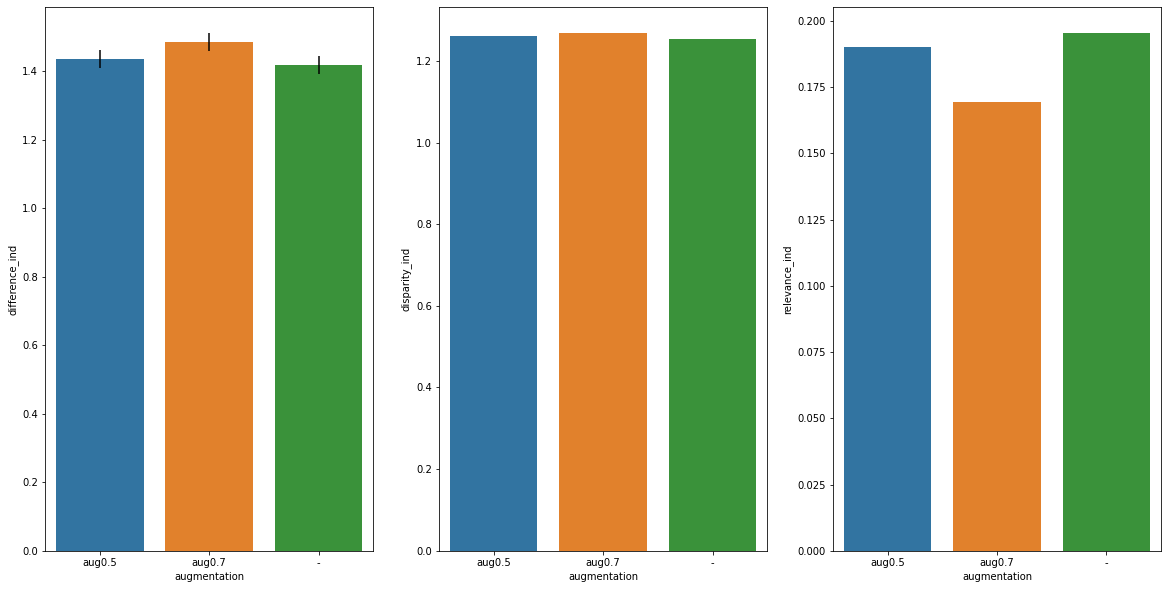

In [350]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('augmentation')
means = groups['difference_ind'].mean()
m1 = means['aug0.5']
n1 = len(groups.get_group('aug0.5'))
m2 = means['aug0.7']
n2 = len(groups.get_group('aug0.7'))
m3 = means['-']
n3 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='augmentation', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lambdata,ax=axs[0])
sns.barplot(x='augmentation', y='disparity_ind', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='augmentation', y='relevance_ind', ci=None, data=lambdata, ax=axs[2])


<AxesSubplot:xlabel='val_metric', ylabel='relevance_ind'>

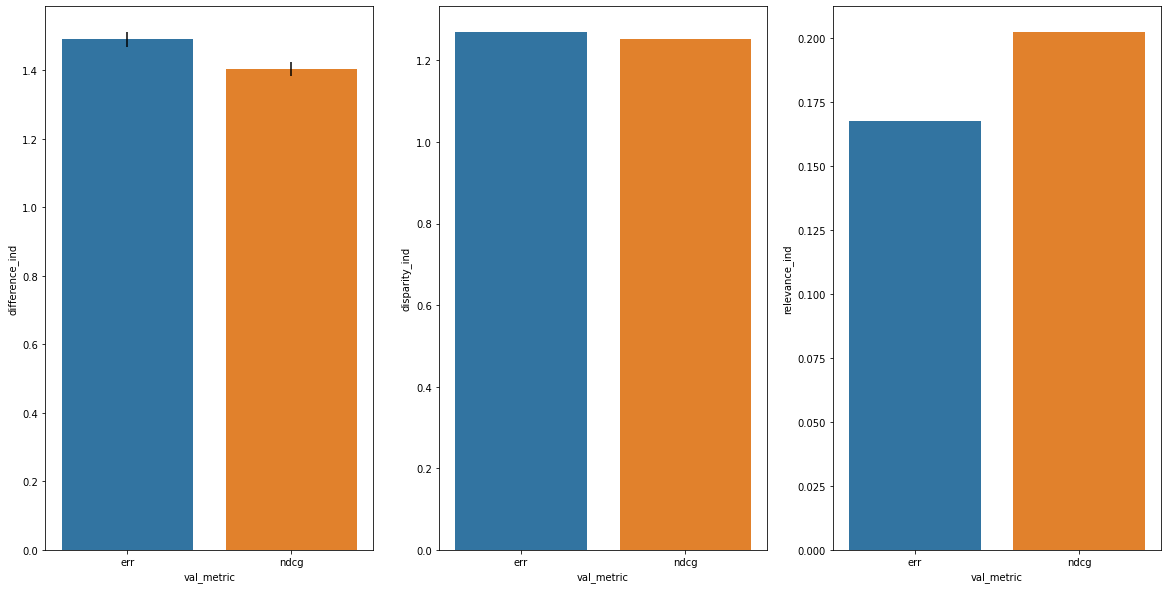

In [351]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference_ind'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

ymax = groups[['difference','disparity','relevance']].mean().max().max() + 0.2
fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='val_metric', y='difference_ind',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity_ind', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance_ind', ci=None, data=lambdata, ax=axs[2])

<AxesSubplot:xlabel='fm_yes_no', ylabel='relevance_ind'>

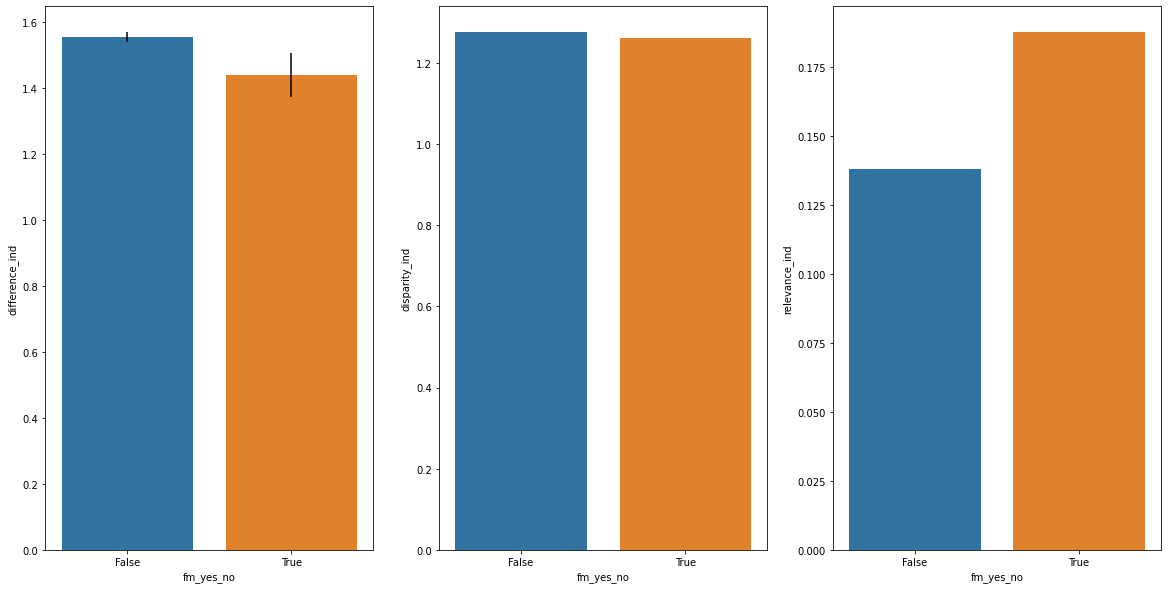

In [352]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('fm_yes_no')
means = groups['difference_ind'].mean()
m1 = means[False]
n1 = len(groups.get_group(True))
m2 = means[True]
n2 = len(groups.get_group(False))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='fm_yes_no', y='difference_ind',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='fm_yes_no', y='disparity_ind',ci=None, data=lambdata,ax=axs[1])
sns.barplot(x='fm_yes_no', y='relevance_ind',ci=None, data=lambdata,ax=axs[2])


### ANOVA feature_method vs EEL_ind
Do it only on the data that has good values for the other factors?

In [353]:
ld_sub = lambdata[(lambdata.augmentation == '-') & (lambdata.val_metric == 'ndcg')]

formula = "difference_ind ~ C(fm_yes_no) + C(qid)"
lm = ols(formula, ld_sub).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(fm_yes_no),1.00000,0.00017,0.00017,0.00105,0.97417
C(qid),19.00000,37.47697,1.97247,12.16365,0.00000
Residual,359.00000,58.21587,0.16216,NaN,NaN


In [354]:
9.741671e-01

0.9741671

In the subset of data with the best ndcg and best augmentation there is no significant effect of feature method.

#### Data with feature selection

In [355]:
test = lambdata.drop('fm_yes_no',axis=1)
test['fm'] = test.apply(lambda df: '_'.join([df.feature_method,df.num_features,df.balancing_factor]),axis=1)
test = test [['difference_ind','disparity_ind','relevance_ind','qid','augmentation','val_metric','feature_method','num_features','balancing_factor','fm']]
test = test.drop_duplicates()
test


,difference_ind,disparity_ind,relevance_ind,qid,augmentation,val_metric,feature_method,num_features,balancing_factor,fm
0,1.68645,1.32943,0.04198,3462,aug0.5,err,mpt,10,0.1,mpt_10_0.1
1,1.90473,1.32943,0.10384,8940,aug0.5,err,mpt,10,0.1,mpt_10_0.1
2,1.53864,1.31771,0.06697,10795,aug0.5,err,mpt,10,0.1,mpt_10_0.1
3,1.46067,1.32943,0.01519,12073,aug0.5,err,mpt,10,0.1,mpt_10_0.1
4,2.07945,1.33332,0.01797,12096,aug0.5,err,mpt,10,0.1,mpt_10_0.1
...,...,...,...,...,...,...,...,...,...,...
2275,1.76113,1.33327,0.00656,64062,-,ndcg,-,-,-,-_-_-
2276,0.52595,1.08236,0.66969,66637,-,ndcg,-,-,-,-_-_-
2277,0.59773,1.08333,0.63429,67404,-,ndcg,-,-,-,-_-_-
2278,1.75083,1.31769,0.17458,70673,-,ndcg,-,-,-,-_-_-


In [356]:
formula = "difference_ind ~ C(augmentation) + C(val_metric) + C(feature_method) + C(qid)"
lm = ols(formula, test).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.78448,0.89224,6.67398,0.00129
C(val_metric),1.00000,4.21711,4.21711,31.54414,0.00000
C(feature_method),2.00000,2.60883,1.30442,9.75710,0.00006
C(qid),19.00000,172.06359,9.05598,67.73913,0.00000
Residual,2255.00000,301.46878,0.13369,NaN,NaN


In [357]:
print_etasq('feature_method')

feature_method
eta-squared	eta-squared partial
0.00541			0.00858



In [358]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=test['difference_ind'], groups=test['feature_method'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     -    mpt  -0.1371 0.0055 -0.2406 -0.0335   True
     -    msd  -0.0914 0.0962  -0.195  0.0121  False
   mpt    msd   0.0456 0.0545 -0.0007   0.092  False
----------------------------------------------------


In [359]:
# augmentation
means = test.groupby('feature_method')['difference_ind'].mean()
m1 = means['-']
m2 = means['mpt']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.3748920698787504


<AxesSubplot:xlabel='feature_method', ylabel='relevance_ind'>

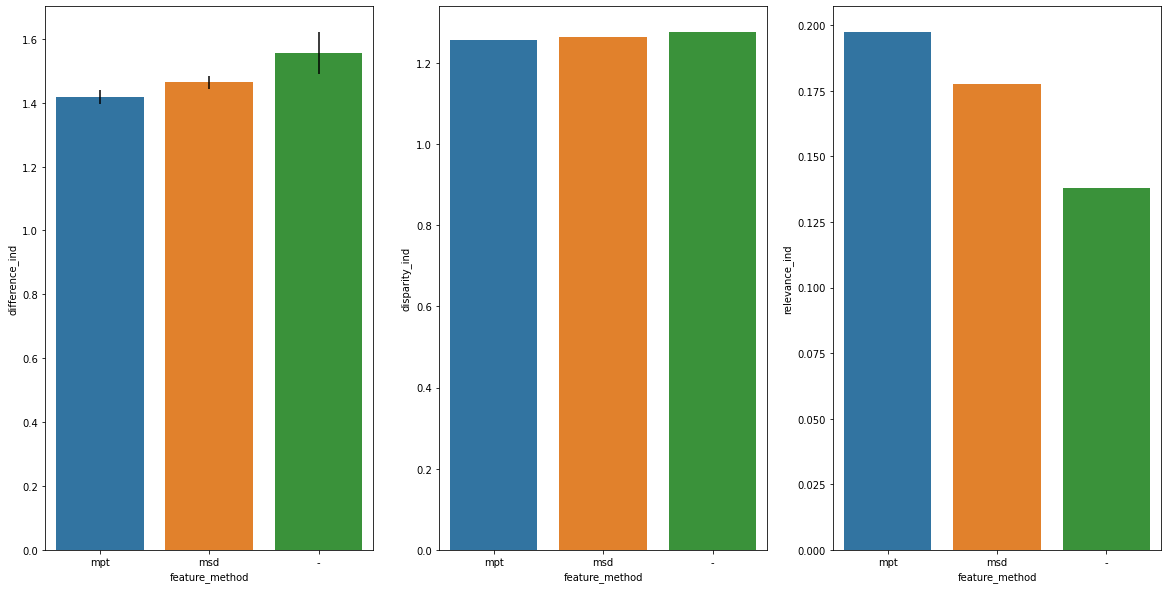

In [360]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = test.groupby('feature_method')
means = groups['difference_ind'].mean()
m3 = means['-']
n3 = len(groups.get_group('-'))
m1 = means['mpt']
n1 = len(groups.get_group('mpt'))
m2 = means['msd']
n2 = len(groups.get_group('msd'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='feature_method', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=test,ax=axs[0])
sns.barplot(x='feature_method', y='disparity_ind', ci=None, data=test, ax=axs[1])
sns.barplot(x='feature_method', y='relevance_ind', ci=None, data=test, ax=axs[2])


In [361]:
formula = "difference_ind ~ C(augmentation) + C(val_metric) + C(num_features) + C(balancing_factor) + C(qid)"
lm = ols(formula, test[test.feature_method == 'mpt']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.20227,0.60114,4.43508,0.01208
C(val_metric),1.00000,3.08481,3.08481,22.75914,0.00000
C(num_features),2.00000,0.06930,0.03465,0.25564,0.77447
C(balancing_factor),2.00000,1.22172,0.61086,4.50683,0.01125
C(qid),19.00000,82.47734,4.34091,32.02647,0.00000
Residual,1053.00000,142.72511,0.13554,NaN,NaN


In [362]:
print_etasq('balancing_factor')

balancing_factor
eta-squared	eta-squared partial
0.00529			0.00849



In [363]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=test[test.feature_method == 'mpt']['difference_ind'], groups=test[test.feature_method == 'mpt']['balancing_factor'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.1    0.5  -0.0665 0.1302 -0.1472 0.0143  False
   0.1    0.9  -0.0754 0.0733 -0.1561 0.0054  False
   0.5    0.9  -0.0089    0.9 -0.0897 0.0719  False
---------------------------------------------------


##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='balancing_factor', ylabel='relevance_ind'>

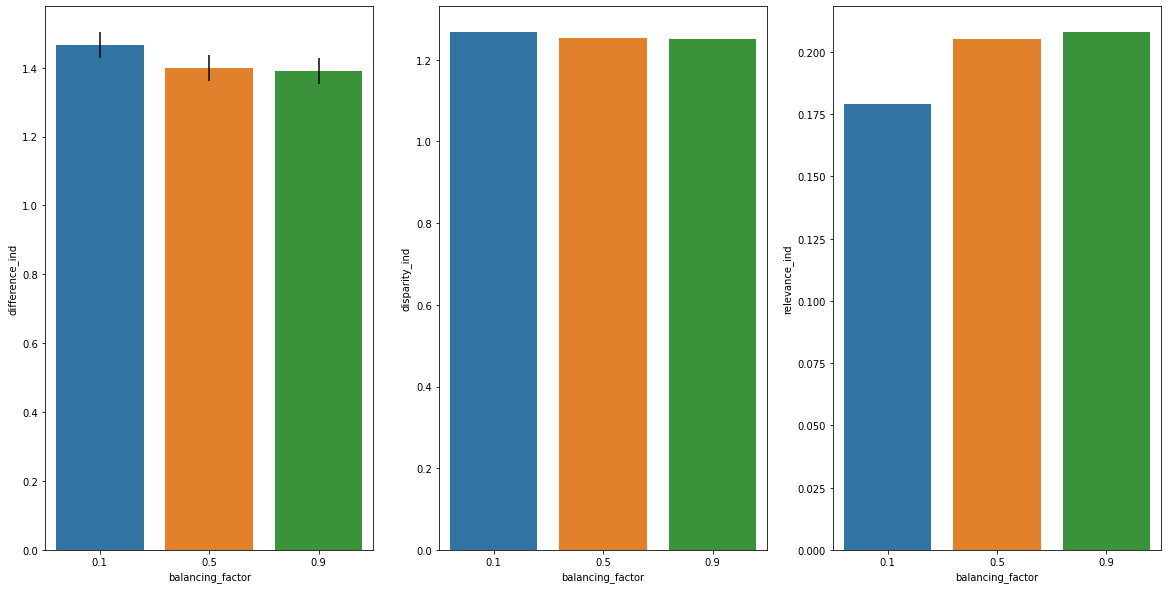

In [364]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = test[test.feature_method == 'mpt'].groupby('balancing_factor')
means = groups['difference_ind'].mean()
m1 = means['0.1']
n1 = len(groups.get_group('0.1'))
m2 = means['0.5']
n2 = len(groups.get_group('0.5'))
m3 = means['0.9']
n3 = len(groups.get_group('0.9'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='balancing_factor', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=test[test.feature_method == 'mpt'],ax=axs[0])
sns.barplot(x='balancing_factor', y='disparity_ind', ci=None, data=test[test.feature_method == 'mpt'], ax=axs[1])
sns.barplot(x='balancing_factor', y='relevance_ind', ci=None, data=test[test.feature_method == 'mpt'], ax=axs[2])


### ANOVA of all main factors vs utility

We only have one replication per cell so we can't look at interactions.

In [365]:
formula = "util ~ C(augmentation) + C(feature_method) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     61.04
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          2.68e-224
Time:                        16:51:06   Log-Likelihood:                 328.38
No. Observations:                2280   AIC:                            -606.8
Df Residuals:                    2255   BIC:                            -463.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1704      0.028      6.031      0.000       0.115       0.226
C(augmentation)[T.aug0.5]     0.0006      0.011      0.053      0.957      -0.021       0.022
C(augmentation)[T.aug0.7]    -0.0268      0.011     -2.476      0.013      -0.048      -0.006
C(feature_method)[T.mpt]      0.0660      0.020      3.257      0.001       0.026       0.106
C(feature_method)[T.msd]      0.0437      0.020      2.155      0.031       0.004       0.083
C(val_metric)[T.ndcg]         0.0456      0.009      5.162      0.000       0.028       0.063
C(qid)[T.8940]               -0.0751      0.028     -2.692      0.007      -0.130      -0.020
C(qid)[T.10795]              -0.0939      0.028     -3.367      0.001      -0.149      -0.039
C(qid)[T.12073]               0.3139      0.028     11.249      0.000       0.259       0.369
C(qid)[T.12096]              -0.1308      0.028     -4.689      0.000      -0.186      -0.076
C(qid)[T.12828]               0.2533      0.028      9.077      0.000       0.199       0.308
C(qid)[T.20363]               0.0195      0.028      0.700      0.484      -0.035       0.074
C(qid)[T.25869]               0.2124      0.028      7.612      0.000       0.158       0.267
C(qid)[T.27887]              -0.2099      0.028     -7.521      0.000      -0.265      -0.155
C(qid)[T.30631]              -0.1850      0.028     -6.629      0.000      -0.240      -0.130
C(qid)[T.31412]               0.1624      0.028      5.818      0.000       0.108       0.217
C(qid)[T.43018]              -0.1754      0.028     -6.285      0.000      -0.230      -0.121
C(qid)[T.49766]               0.1557      0.028      5.581      0.000       0.101       0.210
C(qid)[T.51432]              -0.1431      0.028     -5.127      0.000      -0.198      -0.088
C(qid)[T.54003]               0.0944      0.028      3.384      0.001       0.040       0.149
C(qid)[T.64062]               0.3539      0.028     12.682      0.000       0.299       0.409
C(qid)[T.66637]               0.1550      0.028      5.553      0.000       0.100       0.210
C(qid)[T.67404]               0.0900      0.028      3.226      0.001       0.035       0.145
C(qid)[T.70673]               0.0310      0.028      1.109      0.267      -0.024       0.086
C(qid)[T.120668]              0.0653      0.028      2.341      0.019       0.011       0.120
==============================================================================
Omnibus:                      100.157   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.698
Skew:                           0.527   Prob(JB):                     3.37e-25
Kurtosis:                       3.277   Cond. No.                         29.1
========================================================

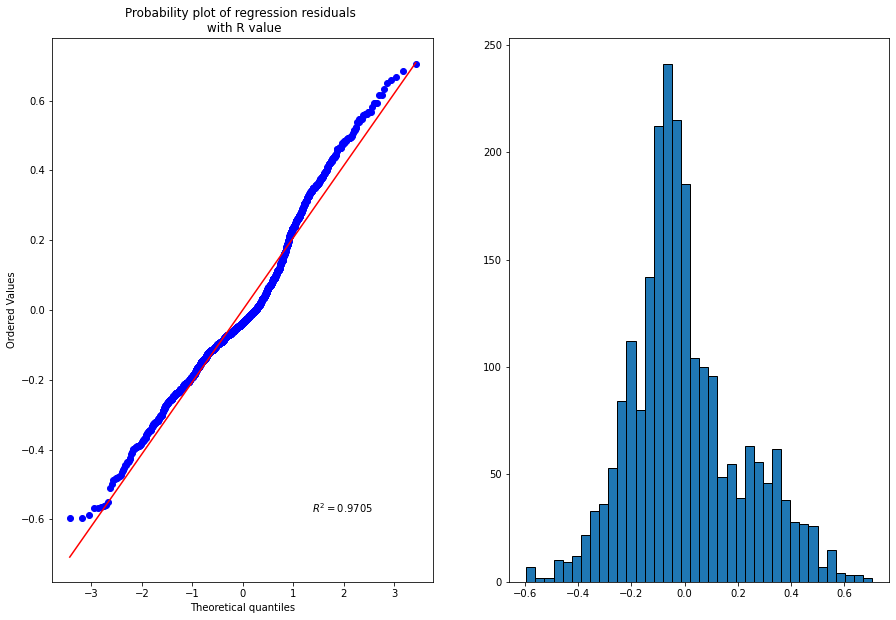

In [366]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [64]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.0,0.370749,0.185374,4.176706,1.546789e-02
C(feature_method),2.0,0.611425,0.305712,6.888067,1.041480e-03
C(val_metric),1.0,1.182682,1.182682,26.647237,2.655712e-07
C(qid),19.0,62.859311,3.308385,74.541888,5.126686e-222
Residual,2255.0,100.083427,0.044383,NaN,NaN


All factors are significant for the utility.

#### ANOVA effect sizes

In [65]:
df_effect = anova_lm(lm).df.loc['C(augmentation)']
ms_effect = anova_lm(lm).mean_sq.loc['C(augmentation)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(lambdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.0017083322140798714
0.0027890305697211323


In [66]:
df_effect = anova_lm(lm).df.loc['C(feature_method)']
ms_effect = anova_lm(lm).mean_sq.loc['C(feature_method)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(lambdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.003166416928138653
0.0051695059873455565


In [67]:
df_effect = anova_lm(lm).df.loc['C(val_metric)']
ms_effect = anova_lm(lm).mean_sq.loc['C(val_metric)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(lambdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.006896137707895282
0.011253724104532705


#### Tukey HSD

In [68]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['util'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0006    0.9 -0.0318 0.0329  False
     - aug0.7  -0.0268  0.128 -0.0591 0.0056  False
aug0.5 aug0.7  -0.0273 0.1173 -0.0597  0.005  False
---------------------------------------------------


In [69]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['util'], groups=lambdata['feature_method'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     -    mpt    0.066  0.029  0.0054 0.1267   True
     -    msd   0.0437 0.2098  -0.017 0.1043  False
   mpt    msd  -0.0223 0.1302 -0.0495 0.0048  False
---------------------------------------------------


In [70]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['util'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   err   ndcg   0.0456 0.001 0.0235 0.0676   True
-------------------------------------------------


#### cohen's d

In [71]:
# augmentation
means = lambdata.groupby('augmentation')['util'].mean()
m_none = means['-']
m_07 = means['aug0.7']
m_05 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m_none, m_07, ms_error))
print(cohens_d(m_none, m_05, ms_error))
print(cohens_d(m_05, m_07, ms_error))


0.12701237352140152
0.0027349589340014955
0.129747332455403


In [72]:
# feature_method
means = lambdata.groupby('feature_method')['util'].mean()
m1 = means['-']
m2 = means['msd']
m3 = means['mpt']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


0.20737173256680713
0.3133831911839776
0.10601145861717051


In [73]:
# val_metric
means = lambdata.groupby('val_metric')['util'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.21621641706267658


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [74]:
ymax = lambdata[['util']].mean().max() + 0.2

<AxesSubplot:xlabel='augmentation', ylabel='util'>

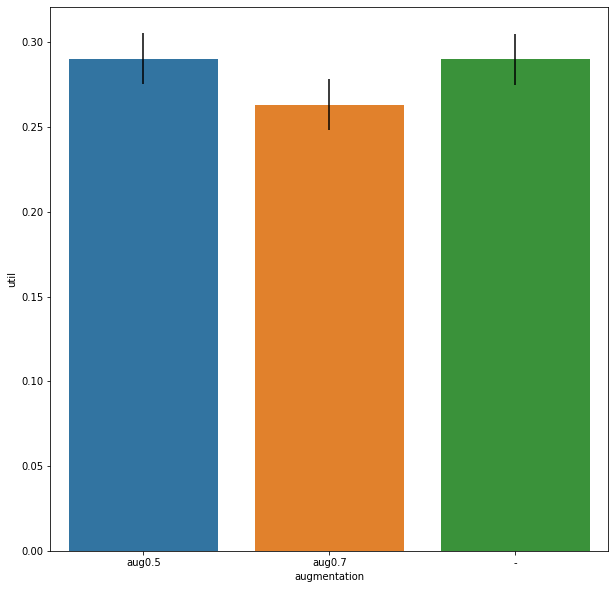

In [75]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('augmentation')
means = groups['util'].mean()
m1 = means['aug0.5']
n1 = len(groups.get_group('aug0.5'))
m2 = means['aug0.7']
n2 = len(groups.get_group('aug0.7'))
m3 = means['-']
n3 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='augmentation', y='util',ci=None, yerr=[c1,c2,c3], data=lambdata,ax=axs)



<AxesSubplot:xlabel='val_metric', ylabel='util'>

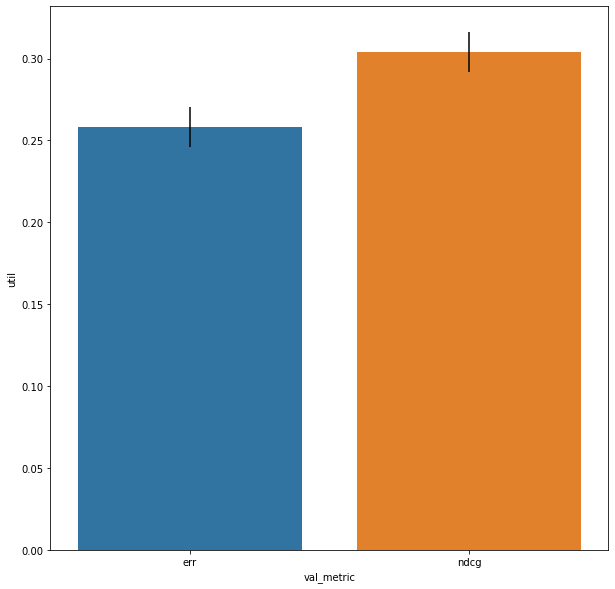

In [76]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['util'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='val_metric', y='util',ci=None, yerr=[c1,c2], data=lambdata,ax=axs)


<AxesSubplot:xlabel='feature_method', ylabel='util'>

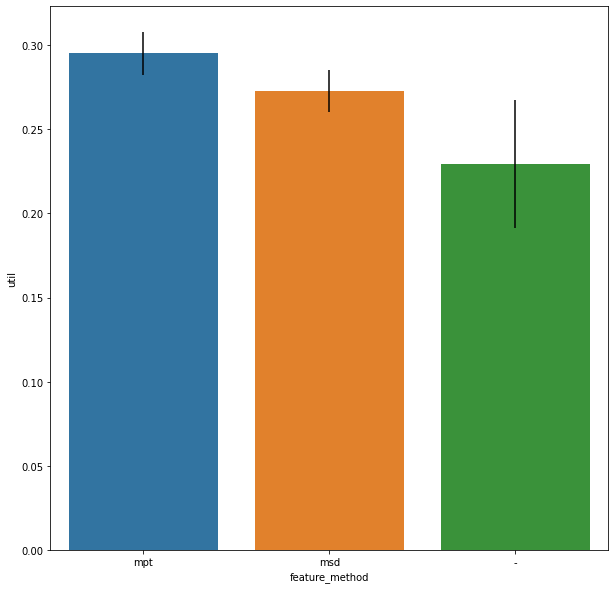

In [77]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('feature_method')
means = groups['util'].mean()
m1 = means['mpt']
n1 = len(groups.get_group('mpt'))
m2 = means['msd']
n2 = len(groups.get_group('msd'))
m3 = means['-']
n3 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,1,figsize=(10,10))

sns.barplot(x='feature_method', y='util',ci=None, yerr=[c1,c2,c3], data=lambdata,ax=axs)


### ANOVA feature_method subfactors vs util

In [109]:
mptdata[mptdata.difference_ind == mptdata.difference_ind.min()]

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
1016,0.000332,1.887271,1.869582,0.284607,1.067587,0.782979,0.805,66637,lambdamart,-,-,-,-,-,-,ndcg,mpt,15,0.9


In [108]:
msddata[msddata.difference_ind == msddata.difference_ind.min()]

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
997,0.002704,1.813947,1.758967,0.284729,1.067708,0.782979,0.805,67404,lambdamart,-,-,-,-,-,-,ndcg,msd,15,0.5


#### MPT

In [102]:
mptdata = lambdata[lambdata.feature_method =='mpt']
mptdata = mptdata.reset_index(drop=True)
mptdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.211684,1.964629,1.433157,1.686451,1.329427,0.041978,0.087503,3462,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
1,1.071827,2.173456,0.996399,1.904734,1.329427,0.103836,0.087910,8940,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
2,0.698335,3.454949,1.983007,1.538637,1.317708,0.066966,0.175418,10795,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
3,0.809104,1.659759,0.755906,1.460666,1.329427,0.015189,0.087618,12073,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
4,0.246748,2.390579,1.938194,2.079445,1.333318,0.017973,0.005475,12096,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.817247,3.396099,1.847155,1.589708,1.317707,0.084491,0.175852,64062,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.9
1076,0.322305,3.718985,2.624453,1.886972,1.329366,0.112687,0.094062,66637,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.9
1077,0.014472,1.796291,1.744254,0.583515,1.083272,0.641368,0.706563,67404,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.9
1078,0.234306,1.641448,1.166381,1.250261,1.266927,0.399479,0.402500,70673,lambdamart,-,-,-,-,-,-,ndcg,mpt,20,0.9


In [103]:
formula = "util ~ C(num_features) + C(balancing_factor) + C(augmentation) + C(val_metric) + C(qid)"
lm = ols(formula, mptdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     29.71
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          5.66e-107
Time:                        13:25:22   Log-Likelihood:                 183.47
No. Observations:                1080   AIC:                            -312.9
Df Residuals:                    1053   BIC:                            -178.3
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2324      0.033      7.110      0.000       0.168       0.297
C(num_features)[T.15]          0.0088      0.015      0.570      0.569      -0.021       0.039
C(num_features)[T.20]          0.0083      0.015      0.538      0.590      -0.022       0.039
C(balancing_factor)[T.0.5]     0.0444      0.015      2.878      0.004       0.014       0.075
C(balancing_factor)[T.0.9]     0.0490      0.015      3.180      0.002       0.019       0.079
C(augmentation)[T.aug0.5]      0.0155      0.015      1.006      0.315      -0.015       0.046
C(augmentation)[T.aug0.7]     -0.0252      0.015     -1.637      0.102      -0.055       0.005
C(val_metric)[T.ndcg]          0.0562      0.013      4.466      0.000       0.032       0.081
C(qid)[T.8940]                -0.0741      0.040     -1.861      0.063      -0.152       0.004
C(qid)[T.10795]               -0.1736      0.040     -4.363      0.000      -0.252      -0.096
C(qid)[T.12073]                0.3011      0.040      7.566      0.000       0.223       0.379
C(qid)[T.12096]               -0.1321      0.040     -3.320      0.001      -0.210      -0.054
C(qid)[T.12828]                0.2310      0.040      5.805      0.000       0.153       0.309
C(qid)[T.20363]               -0.0300      0.040     -0.754      0.451      -0.108       0.048
C(qid)[T.25869]                0.0818      0.040      2.056      0.040       0.004       0.160
C(qid)[T.27887]               -0.2721      0.040     -6.839      0.000      -0.350      -0.194
C(qid)[T.30631]               -0.2338      0.040     -5.876      0.000      -0.312      -0.156
C(qid)[T.31412]                0.1220      0.040      3.067      0.002       0.044       0.200
C(qid)[T.43018]               -0.2691      0.040     -6.762      0.000      -0.347      -0.191
C(qid)[T.49766]                0.0206      0.040      0.518      0.605      -0.057       0.099
C(qid)[T.51432]               -0.1923      0.040     -4.832      0.000      -0.270      -0.114
C(qid)[T.54003]                0.1193      0.040      2.997      0.003       0.041       0.197
C(qid)[T.64062]                0.3039      0.040      7.636      0.000       0.226       0.382
C(qid)[T.66637]                0.1047      0.040      2.631      0.009       0.027       0.183
C(qid)[T.67404]                0.0513      0.040      1.289      0.198      -0.027       0.129
C(qid)[T.70673]                0.0337      0.040      0.848      0.397      -0.044       0.112
C(qid)[T.120668]               0.0281      0.040      0.706      0.480      -0.050       0.106
==============================================================================
Omnibus:                       32.741   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.

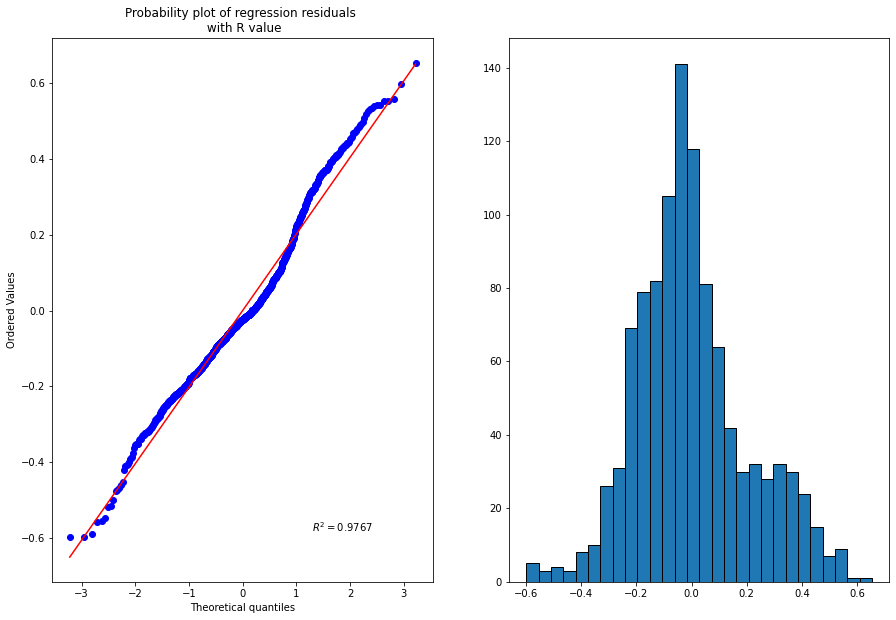

In [104]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [105]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(num_features),2.0,0.017537,0.008769,0.205102,8.145970e-01
C(balancing_factor),2.0,0.526924,0.263462,6.162424,2.183909e-03
C(augmentation),2.0,0.304221,0.152111,3.557890,2.884200e-02
C(val_metric),1.0,0.852732,0.852732,19.945543,8.827882e-06
C(qid),19.0,31.328789,1.648884,38.567660,1.073247e-106
Residual,1053.0,45.018922,0.042753,NaN,NaN


Balancing factor are significantly different.

##### ANOVA effect sizes

In [85]:
df_effect = anova_lm(lm).df.loc['C(balancing_factor)']
ms_effect = anova_lm(lm).mean_sq.loc['C(balancing_factor)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(mptdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.005633841840161072
0.009323078371530524


##### Tukey HSD

In [87]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=mptdata['util'], groups=mptdata['balancing_factor'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.1    0.5   0.0444 0.0687 -0.0026 0.0913  False
   0.1    0.9    0.049 0.0383  0.0021 0.0959   True
   0.5    0.9   0.0047    0.9 -0.0423 0.0516  False
---------------------------------------------------


##### cohen's d

In [89]:
# augmentation
means = mptdata.groupby('balancing_factor')['util'].mean()
m1 = means['0.1']
m2 = means['0.5']
m3 = means['0.9']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


0.21209037360688351
0.2343913934202614
0.02230101981337791


##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='balancing_factor', ylabel='util'>

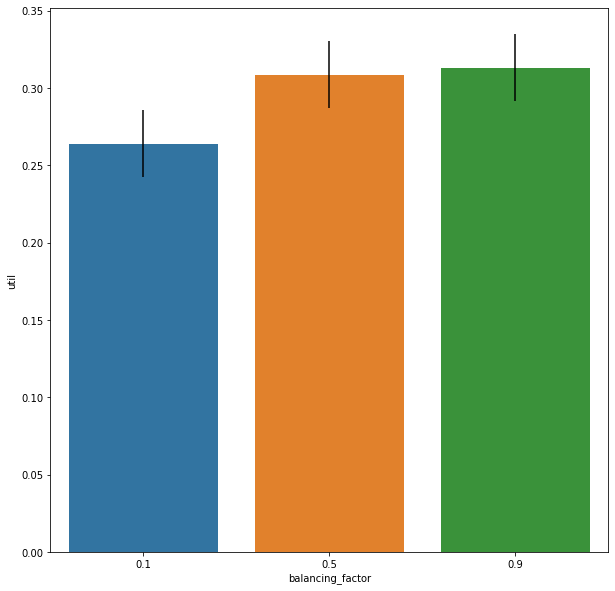

In [90]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = mptdata.groupby('balancing_factor')
means = groups['util'].mean()
m1 = means['0.1']
n1 = len(groups.get_group('0.1'))
m2 = means['0.5']
n2 = len(groups.get_group('0.5'))
m3 = means['0.9']
n3 = len(groups.get_group('0.9'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='balancing_factor', y='util',ci=None, yerr=[c1,c2,c3], data=mptdata,ax=axs)


0.9: title_bm25, year, tsq_expr_abstract_tf_idf, paperAbstractlength_char, titlelength_token, fields_of_studylength_char, inCitations, author_nameslength_char, author_nameslength_token, journalNamelength_token
0.5: 

#### MSD

In [91]:
msddata = lambdata[lambdata.feature_method =='msd']
msddata = msddata.reset_index(drop=True)
msddata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.616724,3.176585,1.836615,1.771973,1.333332,0.001170,0.001369,3462,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.1
1,1.363640,2.737027,1.132278,2.040750,1.333272,0.037751,0.011348,8940,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.1
2,0.684244,3.388742,1.956949,1.679249,1.333272,0.004442,0.011173,10795,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.1
3,1.276108,1.638351,0.511700,1.452367,1.329182,0.019215,0.101161,12073,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.1
4,0.243128,3.244921,2.367175,2.049198,1.333089,0.032981,0.022285,12096,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.340418,2.195994,1.485517,0.838148,1.083089,0.342962,0.713376,64062,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9
1076,0.105383,2.840249,2.293546,1.239207,1.266927,0.405350,0.402500,66637,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9
1077,0.094825,2.571970,2.091918,1.356158,1.270589,0.348705,0.363125,67404,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9
1078,1.683939,3.546341,1.394011,2.002360,1.332356,0.056144,0.044570,70673,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9


In [93]:
formula = "util ~ C(num_features) + C(balancing_factor) + C(qid)"
lm = ols(formula, msddata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     38.58
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.39e-122
Time:                        13:19:11   Log-Likelihood:                 218.83
No. Observations:                1080   AIC:                            -389.7
Df Residuals:                    1056   BIC:                            -270.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1699      0.030      5.703      0.000       0.111       0.228
C(num_features)[T.15]         -0.0039      0.015     -0.265      0.791      -0.033       0.025
C(num_features)[T.20]         -0.0023      0.015     -0.156      0.876      -0.032       0.027
C(balancing_factor)[T.0.5]     0.0307      0.015      2.058      0.040       0.001       0.060
C(balancing_factor)[T.0.9]     0.0726      0.015      4.877      0.000       0.043       0.102
C(qid)[T.8940]                -0.0977      0.038     -2.540      0.011      -0.173      -0.022
C(qid)[T.10795]               -0.0259      0.038     -0.674      0.501      -0.101       0.050
C(qid)[T.12073]                0.2856      0.038      7.428      0.000       0.210       0.361
C(qid)[T.12096]               -0.1449      0.038     -3.769      0.000      -0.220      -0.069
C(qid)[T.12828]                0.2840      0.038      7.384      0.000       0.208       0.359
C(qid)[T.20363]                0.0350      0.038      0.910      0.363      -0.040       0.110
C(qid)[T.25869]                0.3180      0.038      8.268      0.000       0.243       0.393
C(qid)[T.27887]               -0.1700      0.038     -4.421      0.000      -0.245      -0.095
C(qid)[T.30631]               -0.1541      0.038     -4.008      0.000      -0.230      -0.079
C(qid)[T.31412]                0.2171      0.038      5.646      0.000       0.142       0.293
C(qid)[T.43018]               -0.1251      0.038     -3.252      0.001      -0.201      -0.050
C(qid)[T.49766]                0.2483      0.038      6.456      0.000       0.173       0.324
C(qid)[T.51432]               -0.1370      0.038     -3.563      0.000      -0.212      -0.062
C(qid)[T.54003]                0.0679      0.038      1.767      0.078      -0.008       0.143
C(qid)[T.64062]                0.4338      0.038     11.279      0.000       0.358       0.509
C(qid)[T.66637]                0.1926      0.038      5.009      0.000       0.117       0.268
C(qid)[T.67404]                0.1039      0.038      2.702      0.007       0.028       0.179
C(qid)[T.70673]                0.0051      0.038      0.132      0.895      -0.070       0.081
C(qid)[T.120668]               0.0749      0.038      1.947      0.052      -0.001       0.150
==============================================================================
Omnibus:                       70.177   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.678
Skew:                           0.629   Prob(JB):                     6.75e-19
Kurtosis:                       3.527   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the 

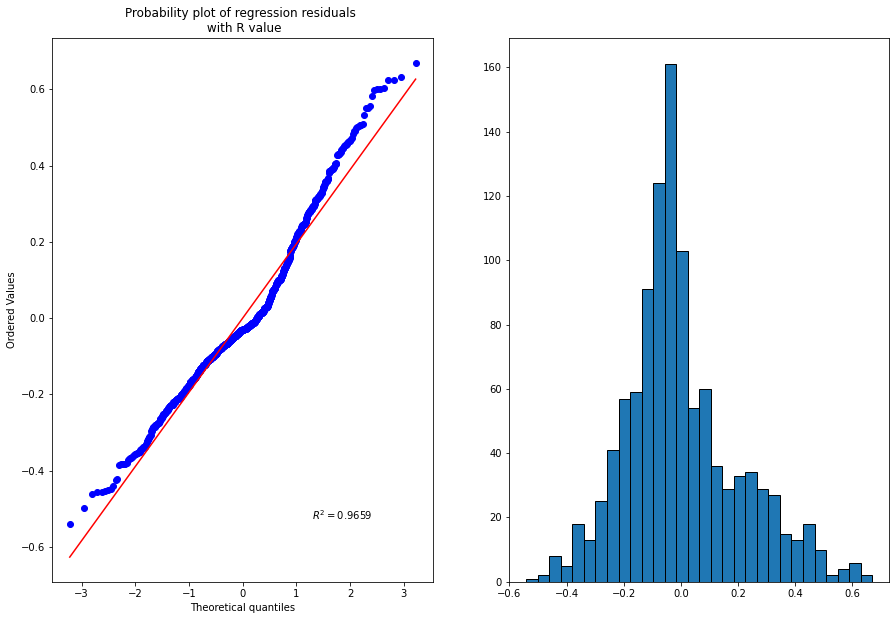

In [94]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [95]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(num_features),2.0,0.002832,0.001416,0.035468,9.651551e-01
C(balancing_factor),2.0,0.957603,0.478802,11.991183,7.088427e-06
C(qid),19.0,34.469087,1.814162,45.434180,1.442448e-122
Residual,1056.0,42.165515,0.039929,NaN,NaN


Balancing factor are significantly different.

##### ANOVA effect sizes

In [96]:
df_effect = anova_lm(lm).df.loc['C(balancing_factor)']
ms_effect = anova_lm(lm).mean_sq.loc['C(balancing_factor)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(msddata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.011317683188428468
0.020391805987473057


##### Tukey HSD

In [97]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=msddata['util'], groups=msddata['balancing_factor'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.1    0.5   0.0307 0.2722  -0.016 0.0773  False
   0.1    0.9   0.0726  0.001   0.026 0.1193   True
   0.5    0.9    0.042 0.0879 -0.0047 0.0887  False
---------------------------------------------------


##### cohen's d

In [98]:

means = msddata.groupby('balancing_factor')['util'].mean()
m1 = means['0.1']
m2 = means['0.5']
m3 = means['0.9']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


0.1534245982759477
0.36354360503622807
0.21011900676028036


##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='balancing_factor', ylabel='util'>

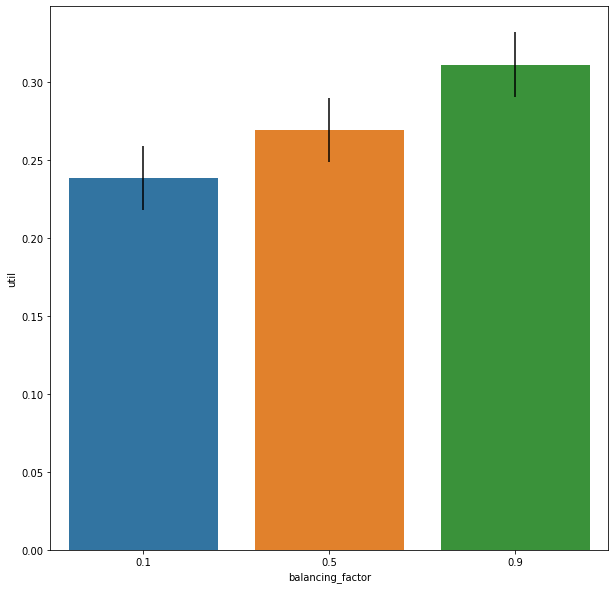

In [99]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = msddata.groupby('balancing_factor')
means = groups['util'].mean()
m1 = means['0.1']
n1 = len(groups.get_group('0.1'))
m2 = means['0.5']
n2 = len(groups.get_group('0.5'))
m3 = means['0.9']
n3 = len(groups.get_group('0.9'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='balancing_factor', y='util',ci=None, yerr=[c1,c2,c3], data=msddata,ax=axs)


Higher balancing factor := more emphasis on feature diversity.

In [101]:
msddata[msddata.balancing_factor == '0.9']

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
40,1.123895,1.503680,0.746577,1.681239,1.329412,0.044577,0.090789,3462,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.9
41,1.404384,1.903554,0.695170,1.983780,1.332357,0.065778,0.043955,8940,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.9
42,0.388889,2.766139,1.793325,1.348152,1.270768,0.138739,0.357695,10795,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.9
43,0.959931,2.277827,0.989526,1.273119,1.266866,0.077682,0.406475,12073,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.9
44,0.018479,1.692380,1.703229,0.608822,1.083333,0.628292,0.700002,12096,lambdamart,-,-,-,-,-,aug0.5,err,msd,10,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.340418,2.195994,1.485517,0.838148,1.083089,0.342962,0.713376,64062,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9
1076,0.105383,2.840249,2.293546,1.239207,1.266927,0.405350,0.402500,66637,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9
1077,0.094825,2.571970,2.091918,1.356158,1.270589,0.348705,0.363125,67404,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9
1078,1.683939,3.546341,1.394011,2.002360,1.332356,0.056144,0.044570,70673,lambdamart,-,-,-,-,-,-,ndcg,msd,20,0.9


## Are the values of the base versions of AC improved by post processing with RFR?

In [215]:
lmrfr = experiments[((experiments.ranker == 'rfr') & (experiments.source == 'lambdamart_ndcg_noaug_nofeat')) | ((experiments.ranker == 'lambdamart') & (experiments.feature_method == '-') & (experiments.augmentation == '-') & (experiments.val_metric == 'ndcg'))]
lmrfr = lmrfr.reset_index(drop=True)
lmrfr

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.57712,2.79229,1.66427,1.68622,1.32940,0.04208,0.08763,3462,lambdamart,-,-,-,-,-,-,ndcg,-,-,-
1,1.21999,2.38827,1.02972,1.98201,1.33236,0.06666,0.04457,8940,lambdamart,-,-,-,-,-,-,ndcg,-,-,-
2,0.46480,2.26661,1.50561,1.61721,1.32943,0.03354,0.08771,10795,lambdamart,-,-,-,-,-,-,ndcg,-,-,-
3,0.38409,1.38503,0.83105,0.96625,1.07941,0.13739,0.75455,12073,lambdamart,-,-,-,-,-,-,ndcg,-,-,-
4,0.17772,2.82322,2.18903,2.05038,1.33309,0.03239,0.02188,12096,lambdamart,-,-,-,-,-,-,ndcg,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.38618,2.47630,1.60279,0.37829,0.20984,0.13627,0.27761,64062,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-
96,0.07816,2.55821,2.16614,0.55271,0.39464,0.31245,0.32153,66637,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-
97,0.20991,1.50974,1.50326,0.55891,0.39690,0.31049,0.31693,67404,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-
98,0.25001,1.36099,1.01830,0.54435,0.33733,0.28764,0.30290,70673,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-


In [217]:
lmrfr.groupby('ranker').difference.mean()

ranker
lambdamart   0.76191
rfr          0.48253
Name: difference, dtype: float64

In [223]:
formula = "difference ~ C(ranker) + C(qid)"
lm = ols(formula, lmrfr).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),1.00000,1.24887,1.24887,27.19939,0.00000
C(qid),19.00000,36.38602,1.91505,41.70828,0.00000
Residual,79.00000,3.62732,0.04592,NaN,NaN


In [224]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.03027			0.25612



In [225]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference'], groups=lmrfr['ranker'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj   lower  upper  reject
-------------------------------------------------------
lambdamart    rfr  -0.2794 0.0834 -0.5964 0.0376  False
-------------------------------------------------------


In [226]:
means = lmrfr.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


1.3038258778691592


<AxesSubplot:xlabel='ranker', ylabel='relevance'>

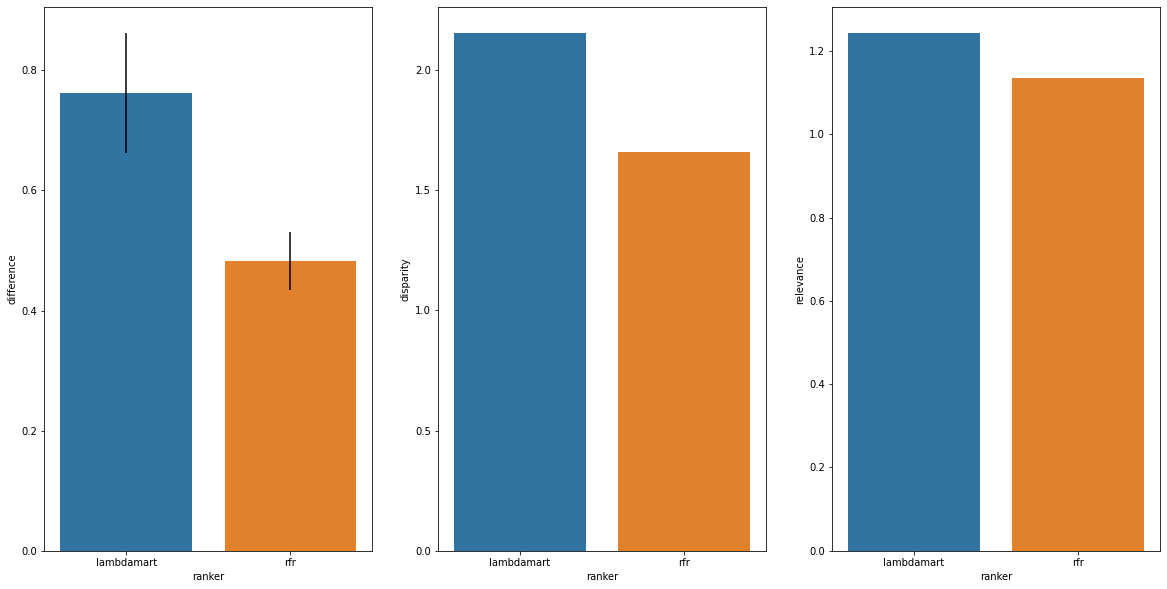

In [227]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('ranker')
means = groups['difference'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=lmrfr, ax=axs[2])


In [228]:
formula = "difference ~ C(group) + C(qid)"
lm = ols(formula, lmrfr[lmrfr.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.04155,0.04155,1.70472,0.19674
C(qid),19.00000,30.15118,1.58690,65.10682,0.00000
Residual,59.00000,1.43806,0.02437,NaN,NaN


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [229]:
lmrfr[lmrfr.ranker == 'rfr'].groupby('group')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
group,,,
auth,0.49569,1.65846,1.12798
doc,0.44306,1.66905,1.15959


The base config of LambdaMart performs best in terms of group difference.

<AxesSubplot:xlabel='group', ylabel='relevance'>

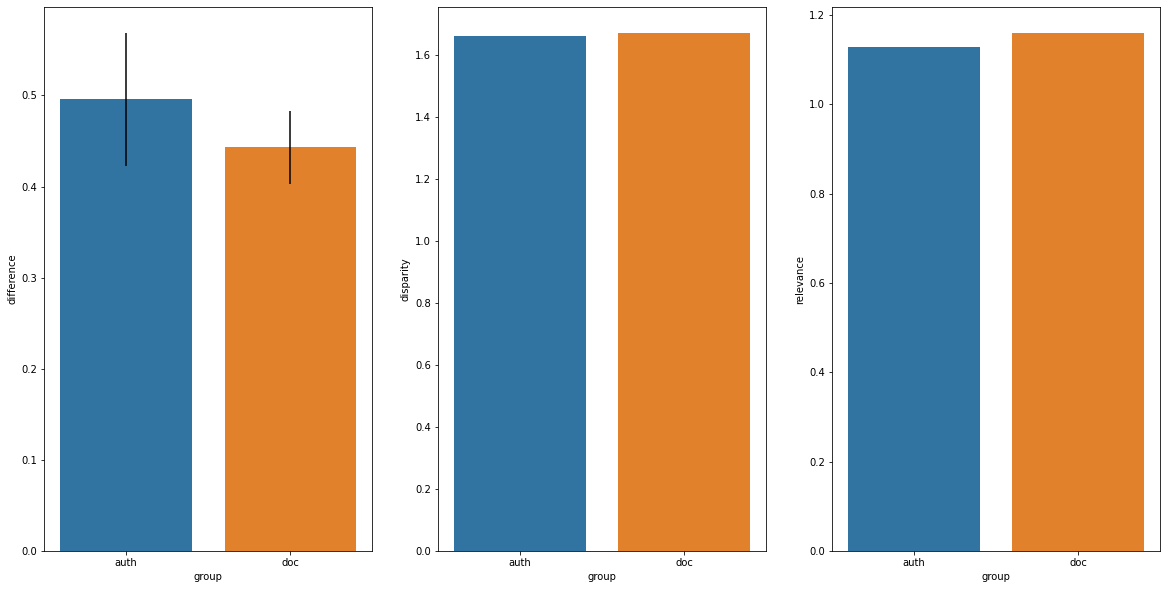

In [230]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].groupby('group')
means = groups['difference'].mean()
m1 = means['doc']
n1 = len(groups.get_group('doc'))
m2 = means['auth']
n2 = len(groups.get_group('auth'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=lmrfr[lmrfr.ranker == 'rfr'],ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[2])


#### jfjfjf

In [244]:
formula = "difference_ind ~ C(ranker) + C(qid)"
lm = ols(formula, lmrfr).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),1.00000,11.33260,11.33260,190.69293,0.00000
C(qid),19.00000,7.84813,0.41306,6.95052,0.00000
Residual,79.00000,4.69485,0.05943,NaN,NaN


In [245]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.47465			0.70707



In [246]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference_ind'], groups=lmrfr['ranker'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj  lower   upper  reject
-------------------------------------------------------
lambdamart    rfr  -0.8416 0.001 -1.0191 -0.6641   True
-------------------------------------------------------


In [247]:
means = lmrfr.groupby('ranker')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


3.4522902813180014


<AxesSubplot:xlabel='ranker', ylabel='relevance_ind'>

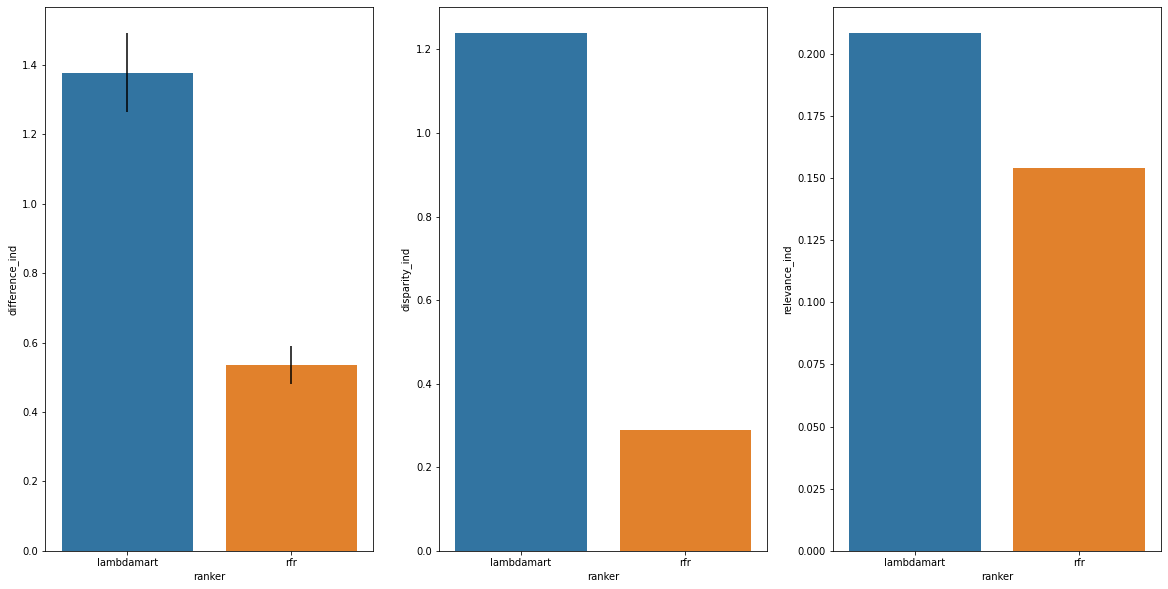

In [248]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=lmrfr, ax=axs[2])


In [249]:
formula = "difference_ind ~ C(group) + C(qid)"
lm = ols(formula, lmrfr[lmrfr.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.08658,0.08658,9.68142,0.00287
C(qid),19.00000,6.41730,0.33775,37.76871,0.00000
Residual,59.00000,0.52762,0.00894,NaN,NaN


In [251]:
print_etasq('group')

group
eta-squared	eta-squared partial
0.01231			0.14096



In [252]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference_ind'], groups=lmrfr[lmrfr.ranker == 'rfr']['group'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  auth    doc   -0.076 0.3271 -0.2294 0.0774  False
---------------------------------------------------


In [253]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('group')['difference_ind'].mean()
m1 = means['auth']
m2 = means['doc']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.8033853714194148


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [254]:
lmrfr[lmrfr.ranker == 'rfr'].groupby('group')[['difference_ind','disparity_ind','relevance_ind']].mean()

,difference_ind,disparity_ind,relevance_ind
group,,,
auth,0.55517,0.30032,0.15025
doc,0.47920,0.25456,0.16535


The base config of LambdaMart performs best in terms of group difference.

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

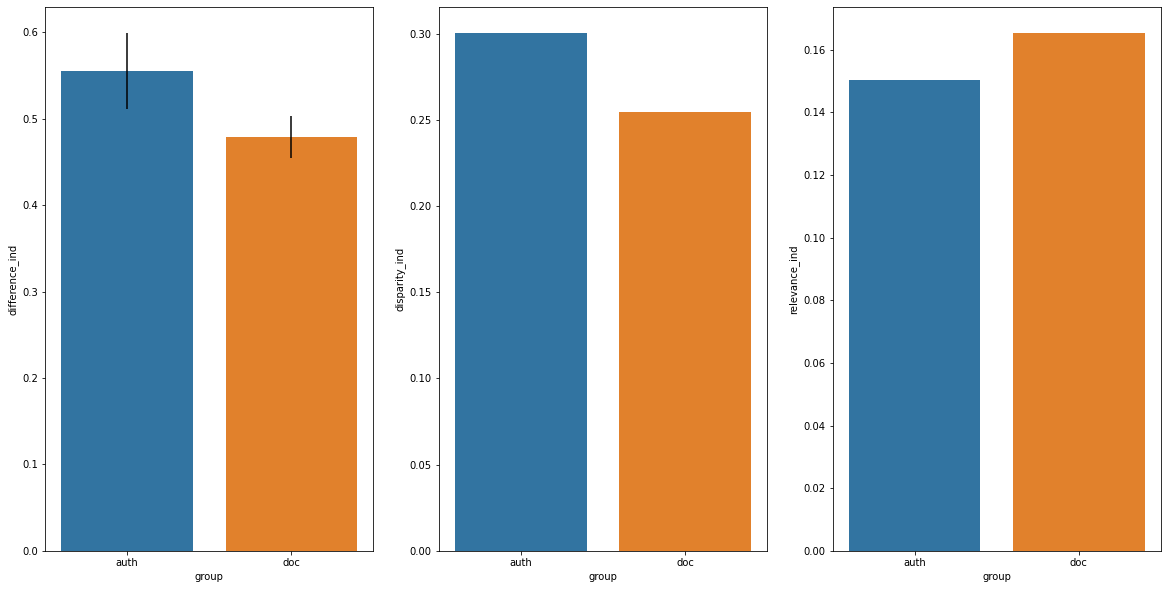

In [255]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].groupby('group')
means = groups['difference_ind'].mean()
m1 = means['doc']
n1 = len(groups.get_group('doc'))
m2 = means['auth']
n2 = len(groups.get_group('auth'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr[lmrfr.ranker == 'rfr'],ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[2])


## Are the values of the base versions of AC improved by our changes?

### Select AC data with KR relevances

In [169]:
ackrdata = experiments[(experiments.ranker == 'ac') & ((experiments.source == 'TEXT_train') | (experiments.source == 'META_train'))]
ackrdata = ackrdata.reset_index(drop=True)
ackrdata.head()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09151,1.73020,1.37603,0.40510,0.11638,0.07613,0.15725,3462,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-
1,0.34400,1.36933,0.95825,0.56015,0.30825,0.26554,0.27069,8940,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-
2,0.11141,1.77696,1.43747,0.31003,0.11223,0.07853,0.20133,10795,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-
3,0.11426,1.09435,0.82062,0.14962,0.09688,0.05444,0.29695,12073,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-
4,0.27833,1.33008,1.39215,0.66967,0.18819,0.15030,0.15480,12096,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-


In [64]:
for col in ['qid','ranker','source','group','subgroup','theta','hfunc']:
    print(Counter(ackrdata[col]))

Counter({3462: 48, 8940: 48, 10795: 48, 12073: 48, 12096: 48, 12828: 48, 20363: 48, 25869: 48, 27887: 48, 30631: 48, 31412: 48, 43018: 48, 49766: 48, 51432: 48, 54003: 48, 64062: 48, 66637: 48, 67404: 48, 70673: 48, 120668: 48})
Counter({'ac': 960})
Counter({'META_train': 480, 'TEXT_train': 480})
Counter({'auth': 720, 'doc': 240})
Counter({'ind': 240, 'none': 240, 'one': 240, '-': 240})
Counter({99.0: 480, 9.0: 480})
Counter({'linear': 320, 'max': 320, 'min': 320})


In [170]:
meta9 = ackrdata[(ackrdata.theta == 9) & (ackrdata.source == 'META_train')].reset_index(drop=True)
meta99 = ackrdata[(ackrdata.theta == 99) & (ackrdata.source == 'META_train')].reset_index(drop=True)
text9 = ackrdata[(ackrdata.theta == 9) & (ackrdata.source == 'TEXT_train')].reset_index(drop=True)
text99 = ackrdata[(ackrdata.theta == 99) & (ackrdata.source == 'TEXT_train')].reset_index(drop=True)
print(len(meta9),len(meta99),len(text9),len(text99))

240 240 240 240


In [66]:
meta9

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.086649,1.672805,1.349763,0.399707,0.108414,0.074844,0.154552,3462,ac,META_train,auth,ind,9.0,linear,-,-,-,-,-
1,0.332967,1.354012,0.956108,0.560596,0.306699,0.264541,0.268607,8940,ac,META_train,auth,ind,9.0,linear,-,-,-,-,-
2,0.091784,1.721694,1.419655,0.301203,0.098897,0.076278,0.196582,10795,ac,META_train,auth,ind,9.0,linear,-,-,-,-,-
3,0.094441,1.000581,0.783649,0.131229,0.079612,0.055000,0.301587,12073,ac,META_train,auth,ind,9.0,linear,-,-,-,-,-
4,0.277303,1.340470,1.397862,0.677831,0.183953,0.144097,0.146683,12096,ac,META_train,auth,ind,9.0,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.268947,2.215327,1.530920,0.339063,0.168460,0.135190,0.275698,64062,ac,META_train,doc,-,9.0,min,-,-,-,-,-
236,0.119663,2.869757,2.301160,0.579559,0.308043,0.255732,0.259395,66637,ac,META_train,doc,-,9.0,min,-,-,-,-,-
237,0.320317,1.410747,1.398560,0.580898,0.308367,0.255224,0.259593,67404,ac,META_train,doc,-,9.0,min,-,-,-,-,-
238,0.425918,1.810703,1.155202,0.641308,0.213343,0.177164,0.182304,70673,ac,META_train,doc,-,9.0,min,-,-,-,-,-


### ANOVA main factors vs EEL

#### meta9

In [186]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, meta9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.06419,0.06419,0.19607,0.65832
C(hfunc),2.00000,0.04633,0.02317,0.07076,0.93171
Residual,236.00000,77.26768,0.32741,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

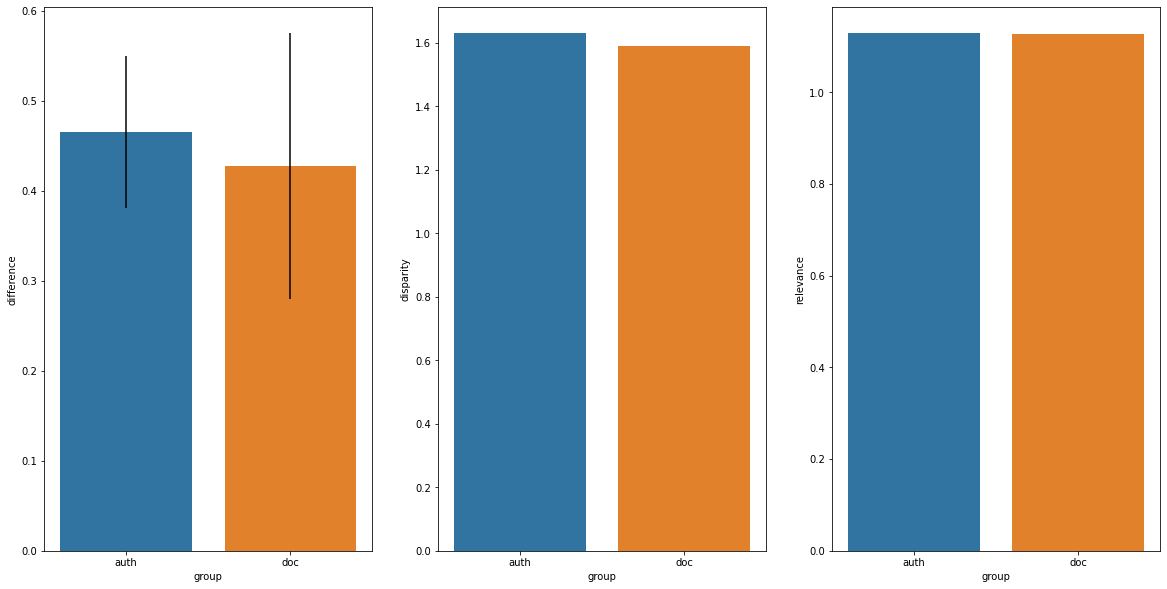

In [172]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=meta9,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=meta9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

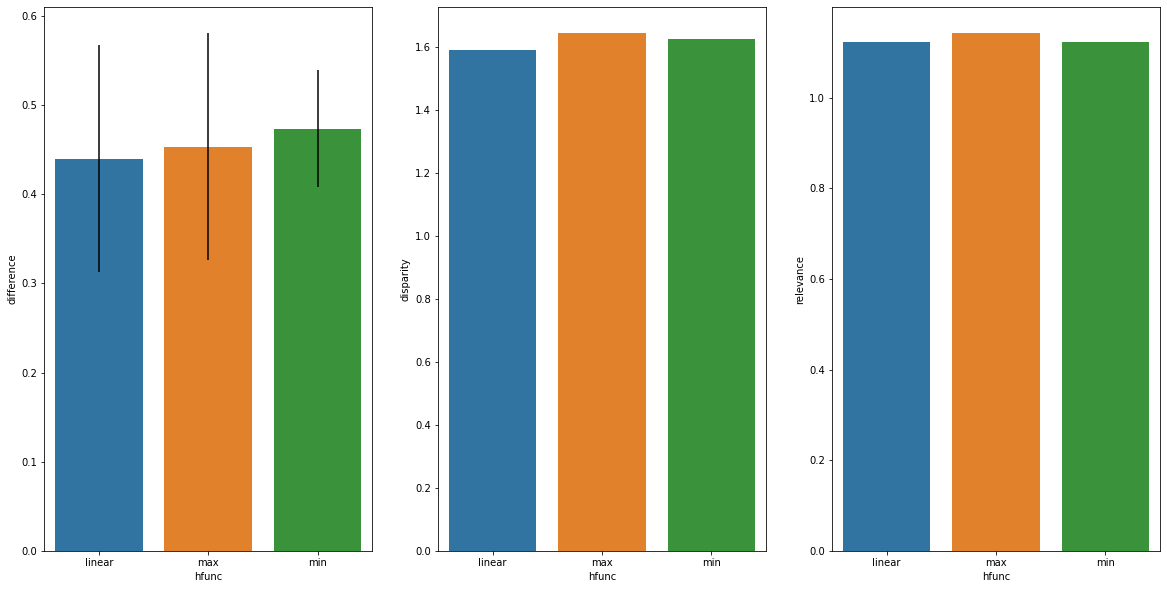

In [173]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=meta9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=meta9, ax=axs[2])

#### meta99

In [174]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, meta99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.02170,0.02170,0.07802,0.78025
C(hfunc),2.00000,0.04355,0.02178,0.07827,0.92474
Residual,236.00000,65.65598,0.27820,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

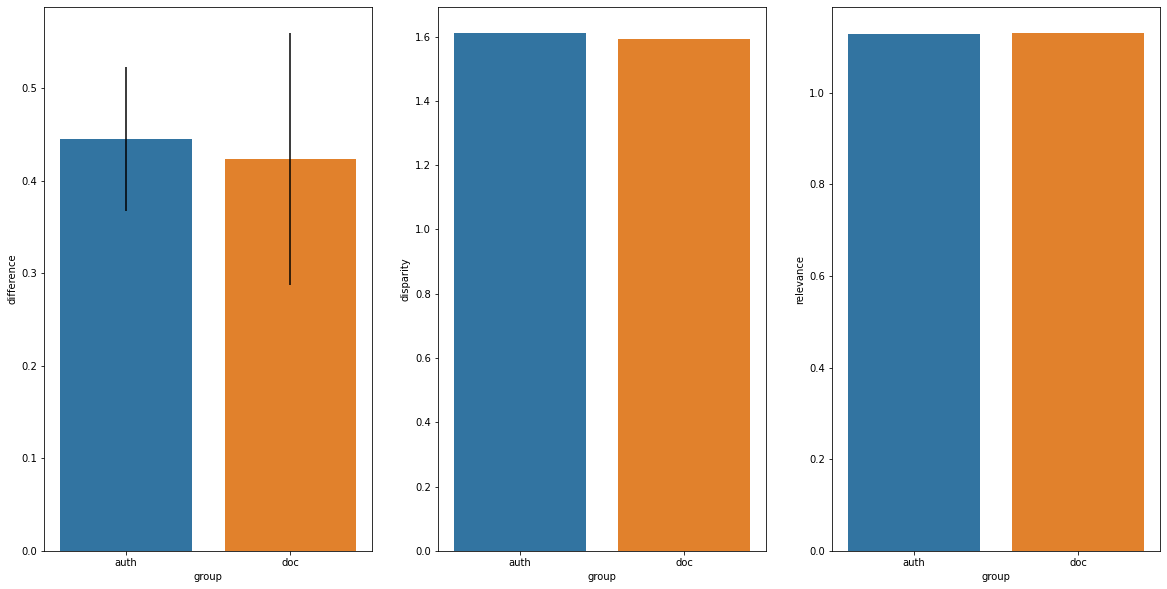

In [175]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=meta99,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=meta99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

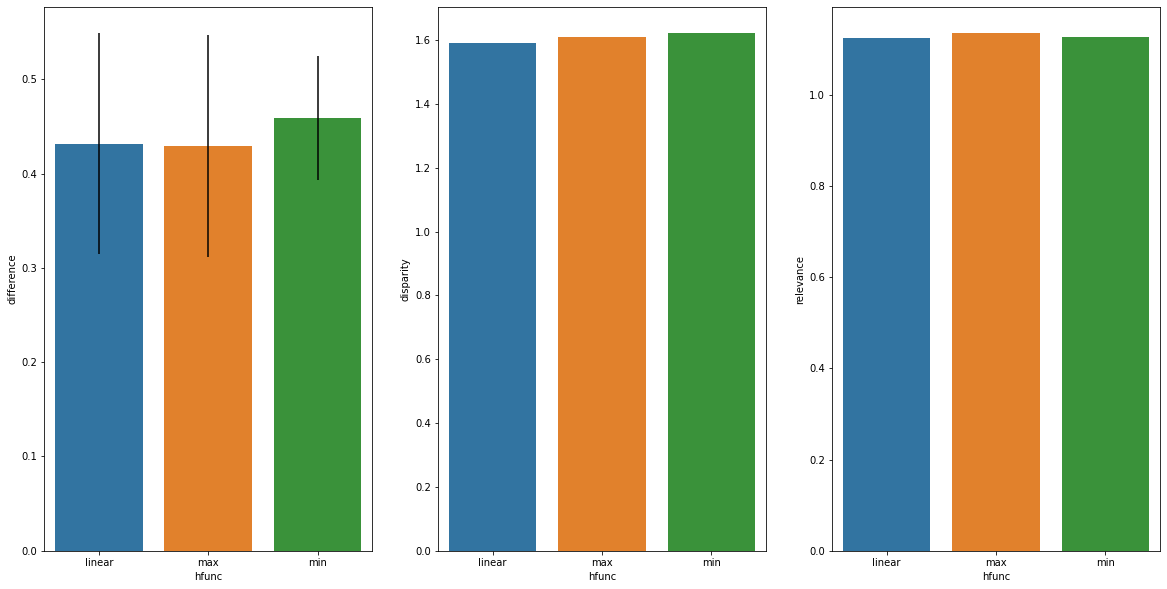

In [176]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=meta99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=meta99, ax=axs[2])

#### text9

In [177]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, text9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.07926,0.07926,0.22371,0.63666
C(hfunc),2.00000,0.03402,0.01701,0.04801,0.95314
Residual,236.00000,83.61128,0.35429,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

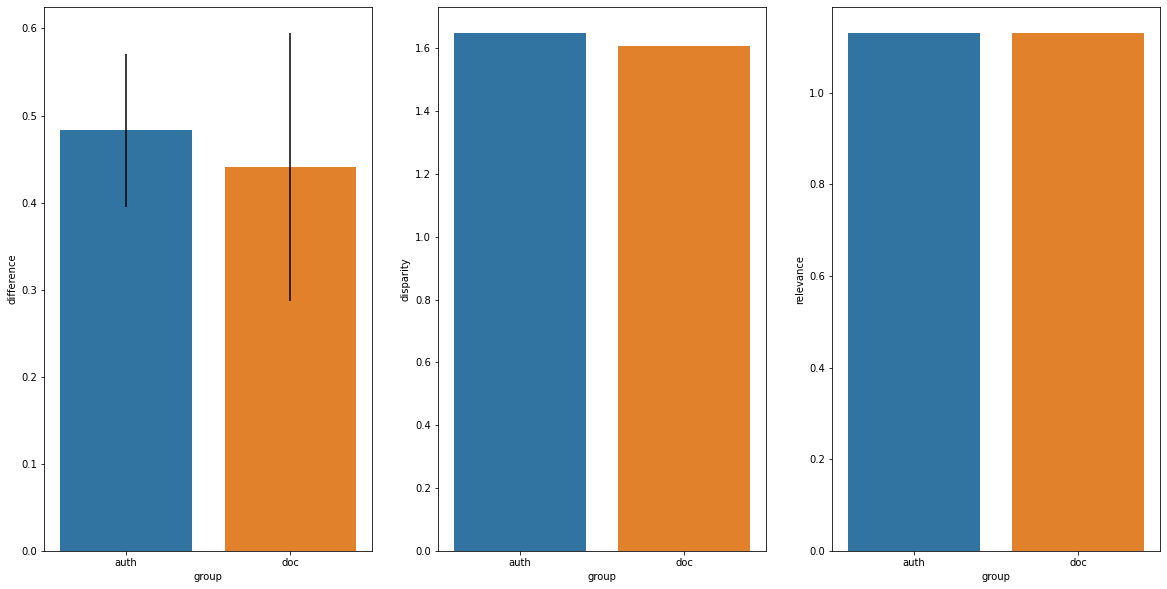

In [178]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=text9,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=text9, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=text9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

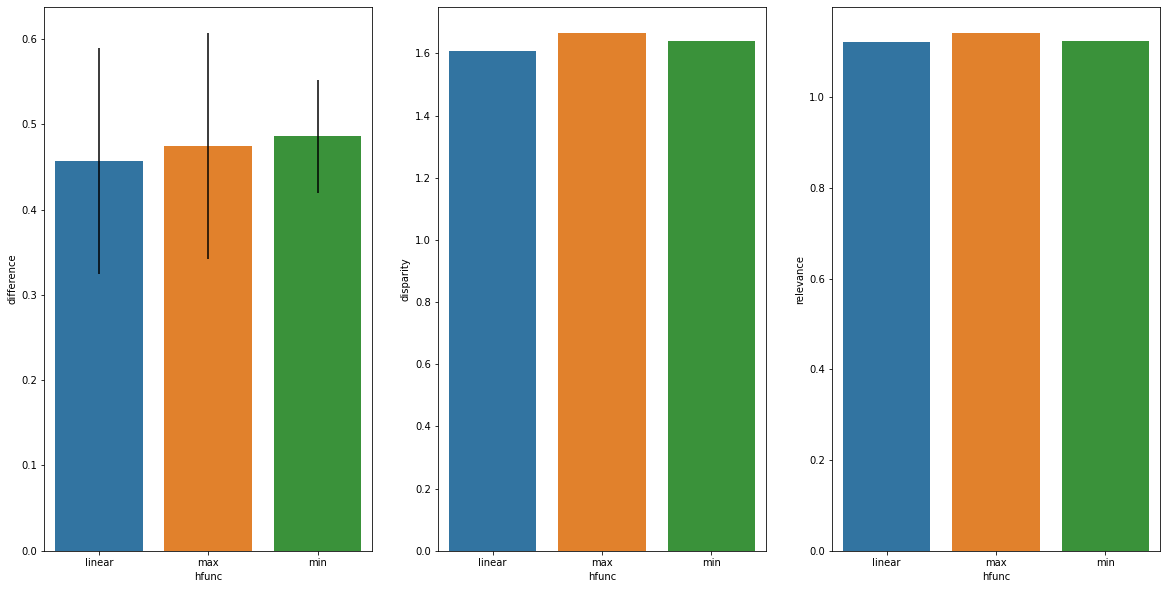

In [179]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=text9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=text9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=text9, ax=axs[2])

#### text99

In [181]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, text99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.05327,0.05327,0.16651,0.68360
C(hfunc),2.00000,0.01550,0.00775,0.02422,0.97607
Residual,236.00000,75.49641,0.31990,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

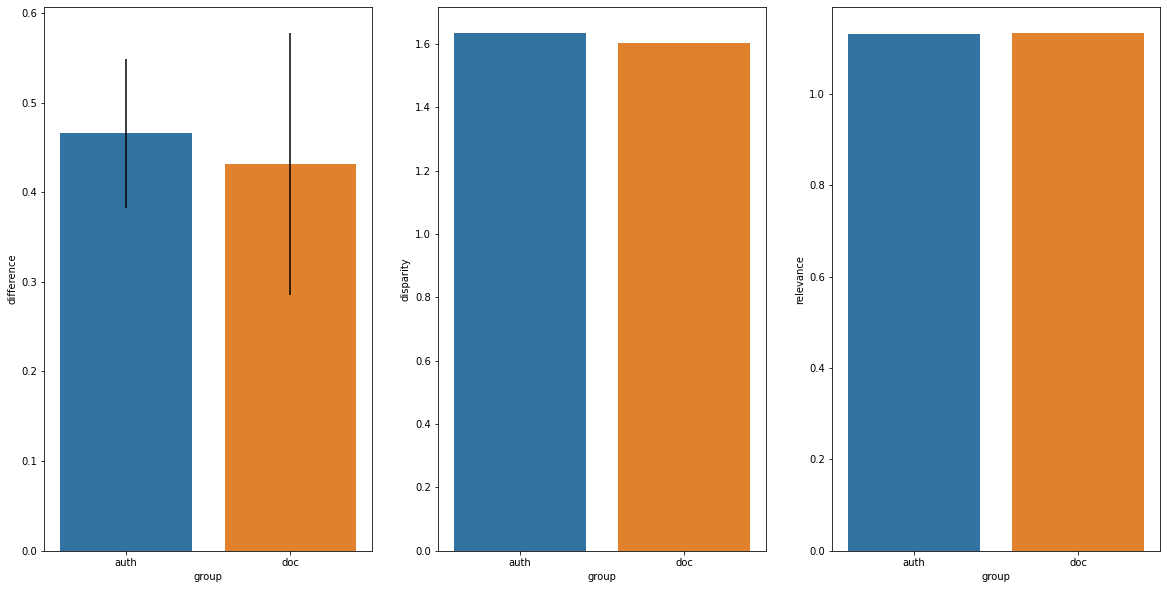

In [182]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=text99,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=text99, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=text99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

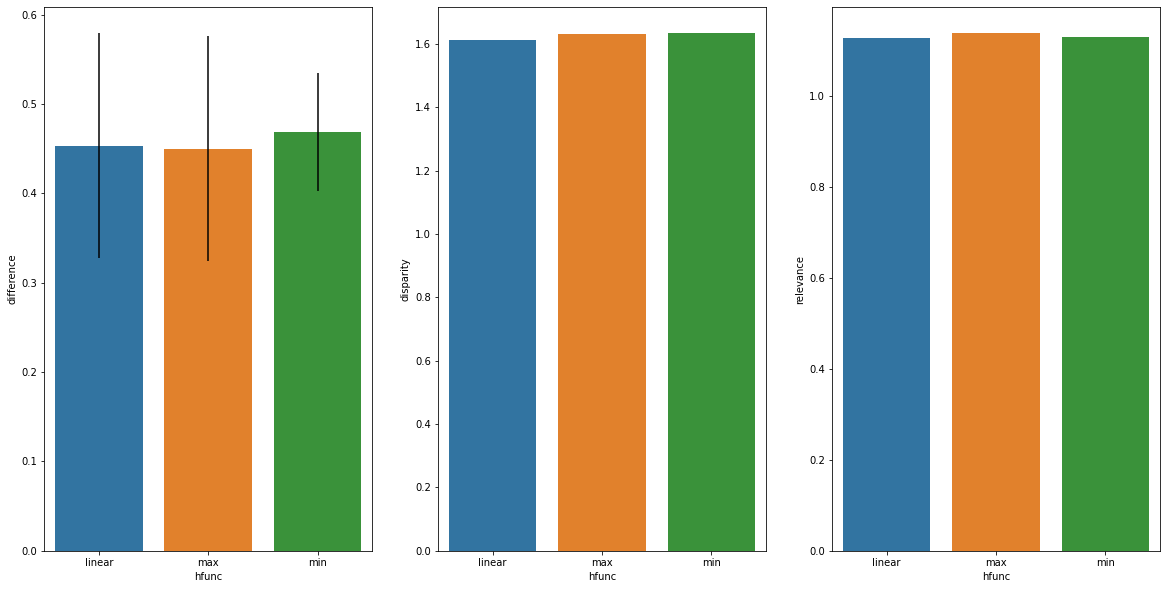

In [183]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=text99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=text99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=text99, ax=axs[2])

### ANOVA main factors vs EEL_ind



#### meta9

In [188]:
formula = "difference_ind ~ C(group) + C(hfunc)"
lm = ols(formula, meta9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.07532,0.07532,1.20594,0.27326
C(hfunc),2.00000,0.12203,0.06102,0.97696,0.37797
Residual,236.00000,14.73929,0.06245,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

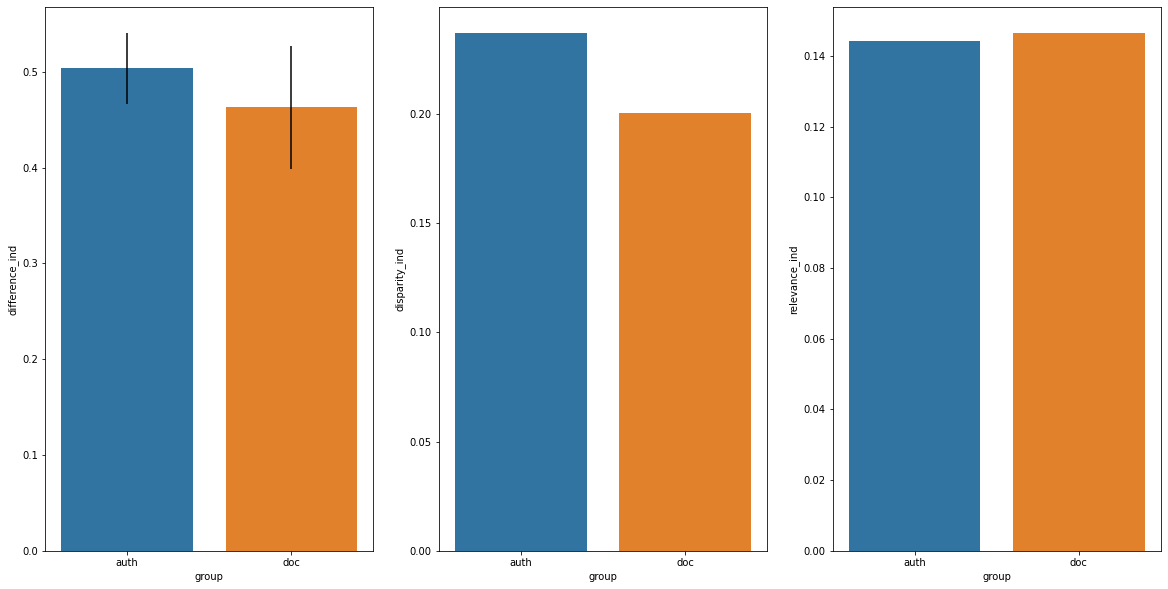

In [189]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=meta9,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=meta9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

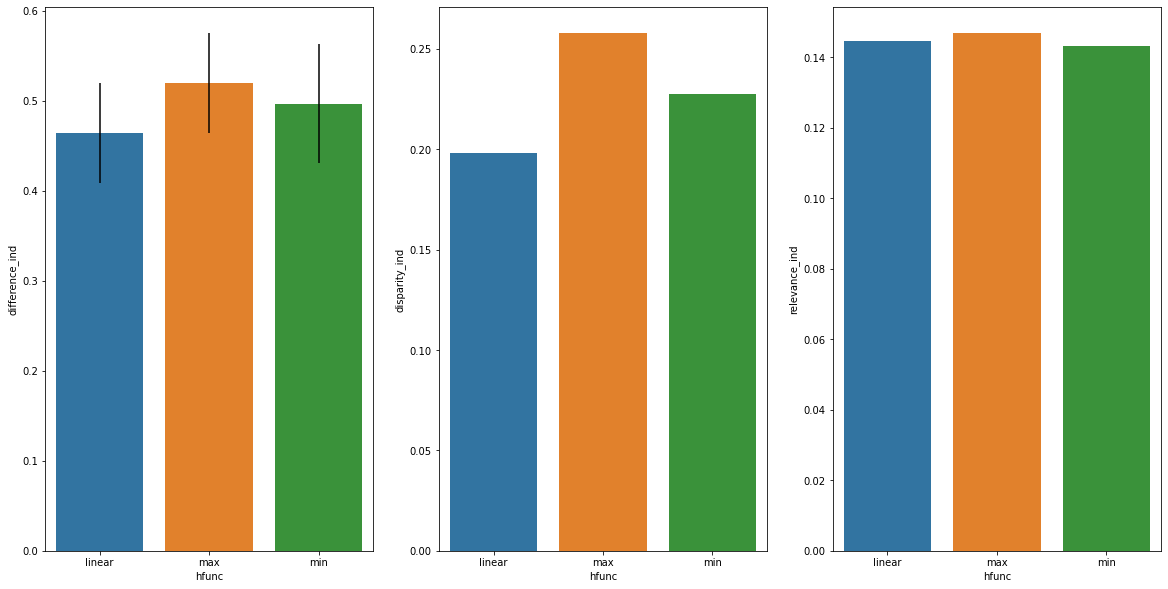

In [190]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=meta9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=meta9, ax=axs[2])

#### meta99

In [193]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, meta99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.02170,0.02170,0.07802,0.78025
C(hfunc),2.00000,0.04355,0.02178,0.07827,0.92474
Residual,236.00000,65.65598,0.27820,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

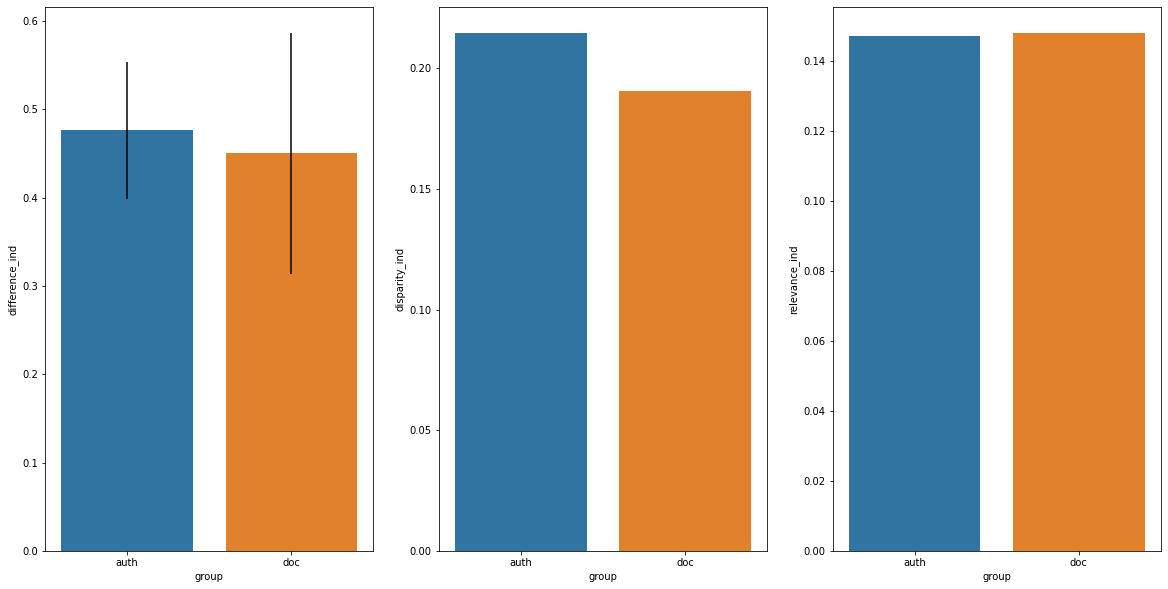

In [194]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=meta99,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=meta99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

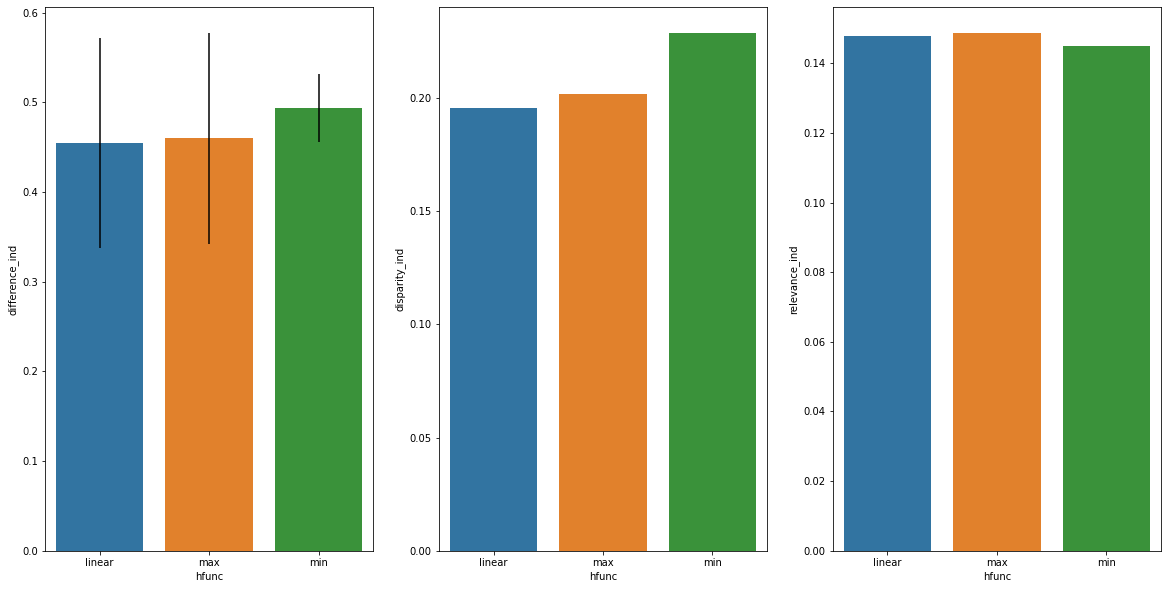

In [96]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=meta99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=meta99, ax=axs[2])

#### text9

In [195]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, text9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.07926,0.07926,0.22371,0.63666
C(hfunc),2.00000,0.03402,0.01701,0.04801,0.95314
Residual,236.00000,83.61128,0.35429,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

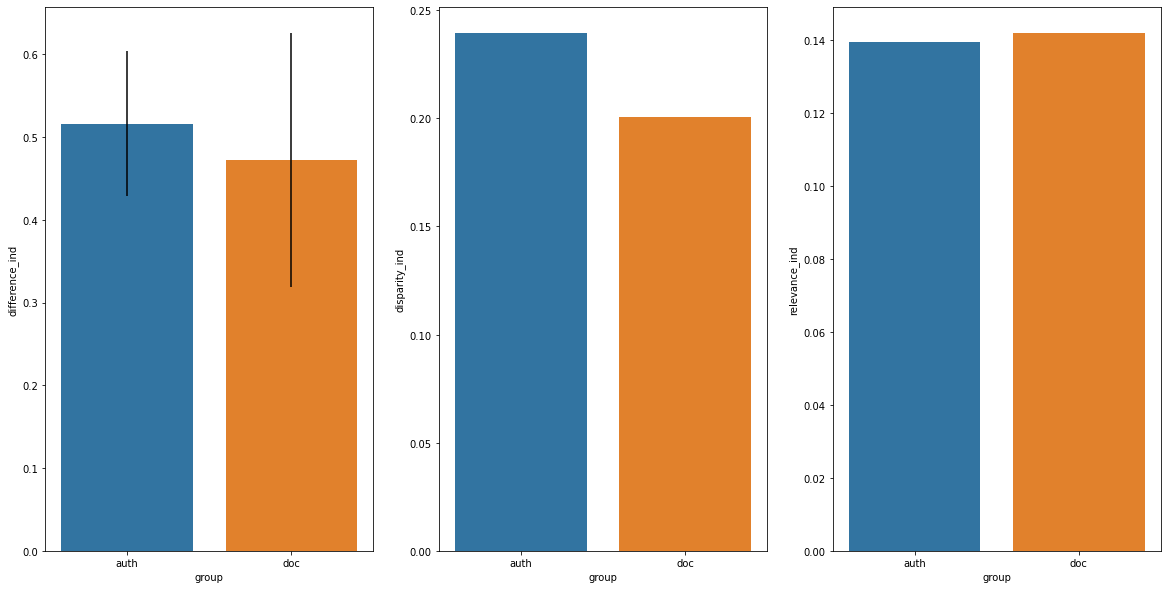

In [196]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=text9,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=text9, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=text9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

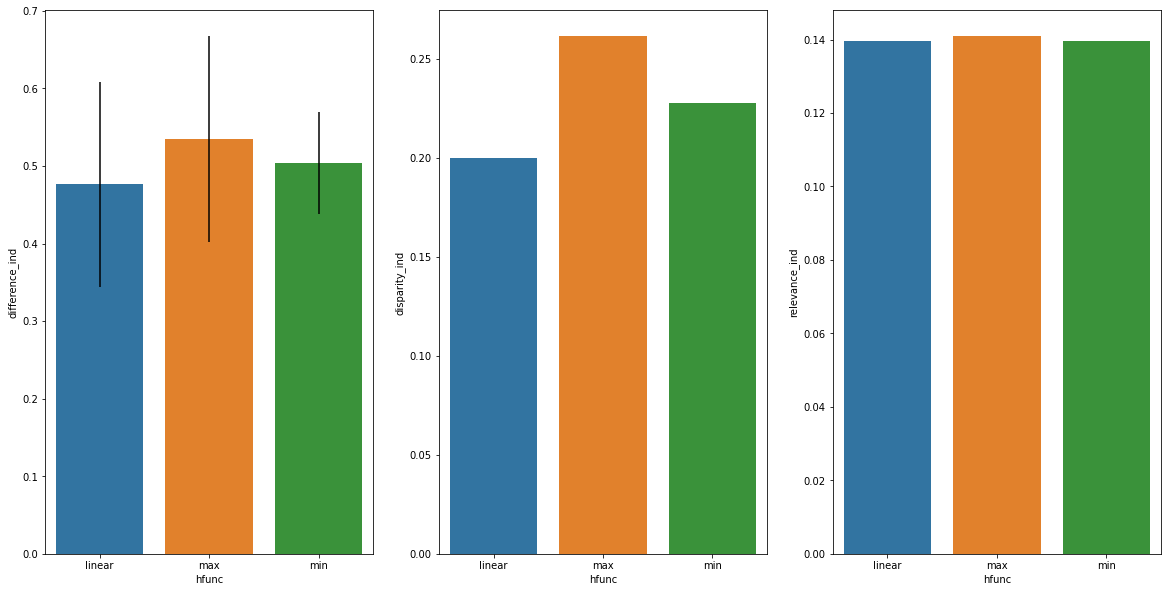

In [197]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=text9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=text9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=text9, ax=axs[2])

#### text99

In [198]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, text99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.05327,0.05327,0.16651,0.68360
C(hfunc),2.00000,0.01550,0.00775,0.02422,0.97607
Residual,236.00000,75.49641,0.31990,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

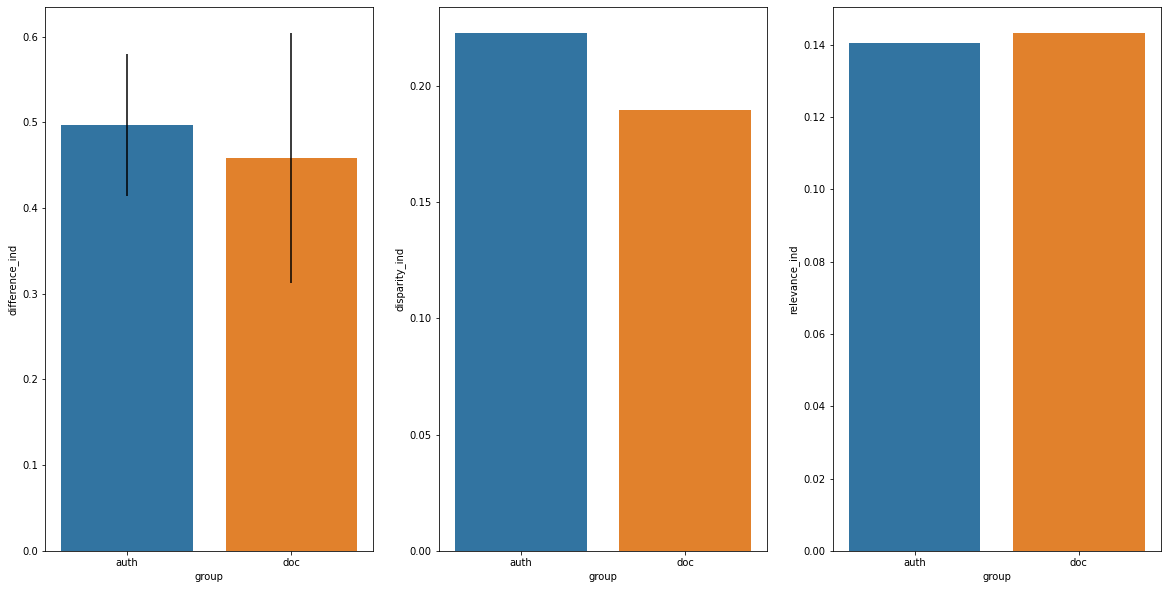

In [200]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=text99,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=text99, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=text99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

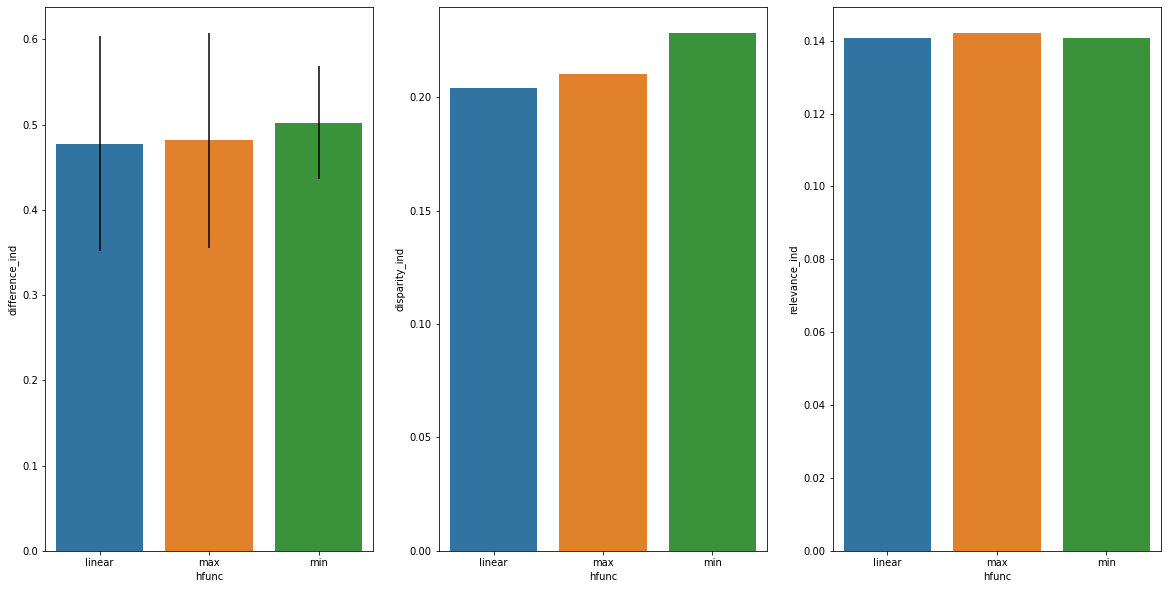

In [201]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=text99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=text99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=text99, ax=axs[2])

### ANOVA main factors vs util



#### meta9

In [107]:
formula = "util ~ C(group) + C(hfunc)"
lm = ols(formula, meta9).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.02353
Date:                Thu, 02 Jun 2022   Prob (F-statistic):              0.995
Time:                        12:04:05   Log-Likelihood:                 209.25
No. Observations:                 240   AIC:                            -410.5
Df Residuals:                     236   BIC:                            -396.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2370      0.012     19.705      0.000       0.213       0.261
C(group)[T.doc]     0.0034      0.015      0.222      0.824      -0.027       0.033
C(hfunc)[T.max]     0.0013      0.016      0.082      0.935      -0.030       0.033
C(hfunc)[T.min]    -0.0010      0.016     -0.064      0.949      -0.033       0.031
==============================================================================
Omnibus:                       42.581   Durbin-Watson:                   2.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.967
Skew:                           1.086   Prob(JB):                     5.77e-14
Kurtosis:                       4.176   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

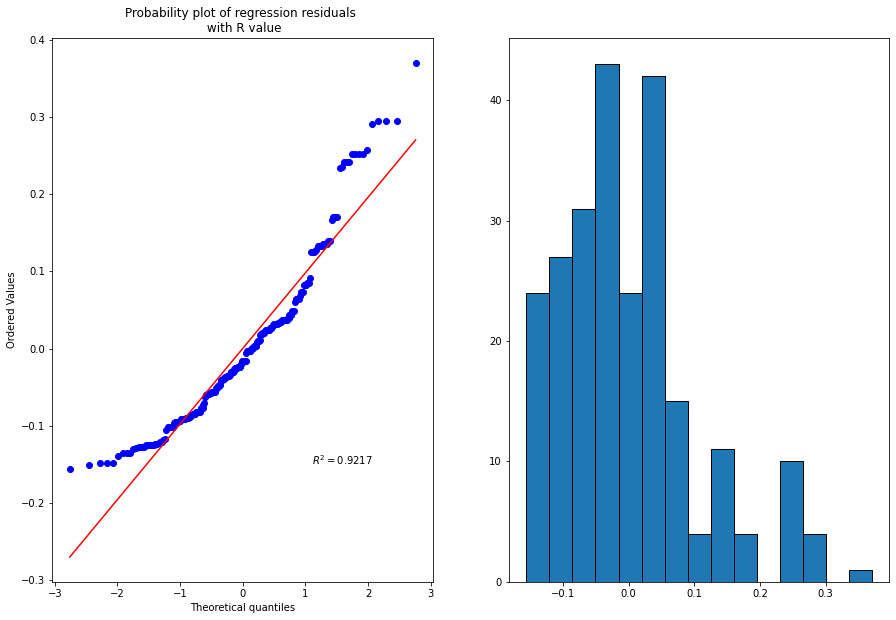

In [108]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [109]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.000513,0.000513,0.049306,0.824467
C(hfunc),2.0,0.000222,0.000111,0.010648,0.989409
Residual,236.0,2.457130,0.010412,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='util'>

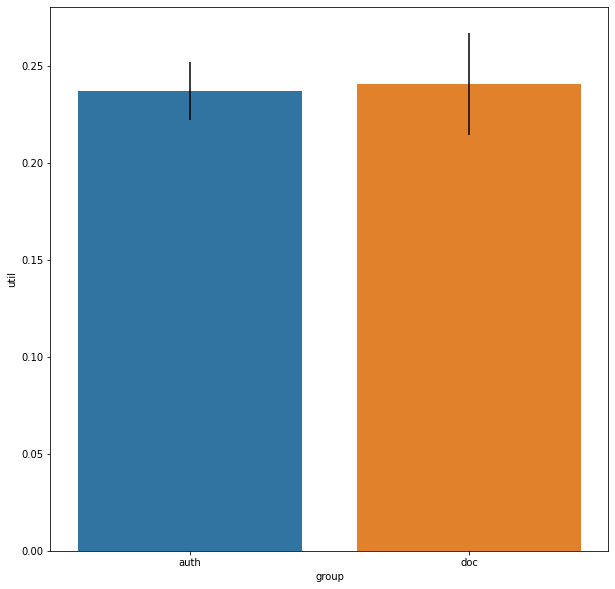

In [110]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('group')
means = groups['util'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='util',ci=None, yerr=[c1,c2], data=meta9,ax=axs)


<AxesSubplot:xlabel='hfunc', ylabel='util'>

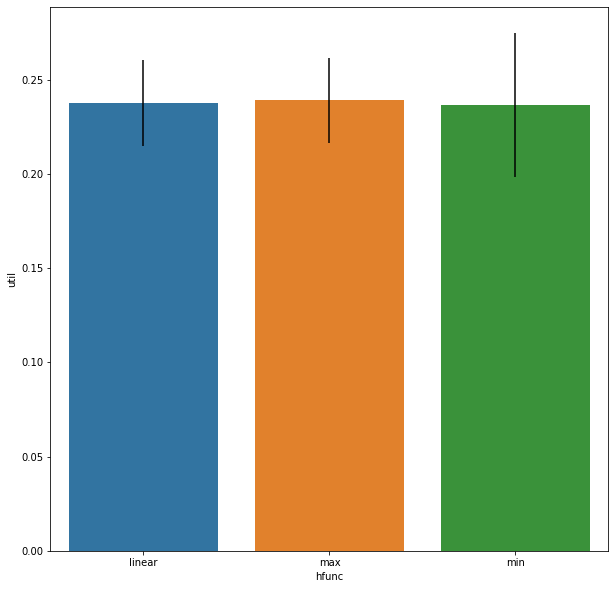

In [111]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('hfunc')
means = groups['util'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,1,figsize=(10,10))

sns.barplot(x='hfunc', y='util',ci=None, yerr=[c1,c2,c3], data=meta9,ax=axs)


#### meta99

In [112]:
formula = "util ~ C(group) + C(hfunc)"
lm = ols(formula, meta99).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.02870
Date:                Thu, 02 Jun 2022   Prob (F-statistic):              0.993
Time:                        12:04:07   Log-Likelihood:                 230.13
No. Observations:                 240   AIC:                            -452.3
Df Residuals:                     236   BIC:                            -438.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2409      0.011     21.855      0.000       0.219       0.263
C(group)[T.doc]     0.0030      0.014      0.215      0.830      -0.024       0.030
C(hfunc)[T.max]     0.0010      0.015      0.069      0.945      -0.028       0.030
C(hfunc)[T.min]    -0.0019      0.015     -0.127      0.899      -0.031       0.027
==============================================================================
Omnibus:                       37.941   Durbin-Watson:                   2.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.666
Skew:                           0.972   Prob(JB):                     2.22e-12
Kurtosis:                       4.259   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

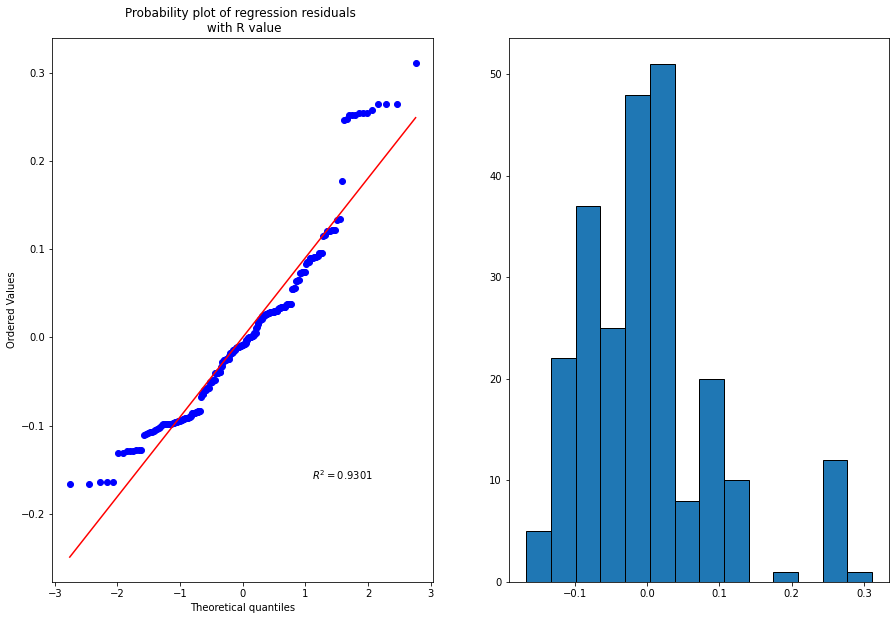

In [113]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [114]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.000406,0.000406,0.046383,0.829667
C(hfunc),2.0,0.000348,0.000174,0.019859,0.980338
Residual,236.0,2.064809,0.008749,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='util'>

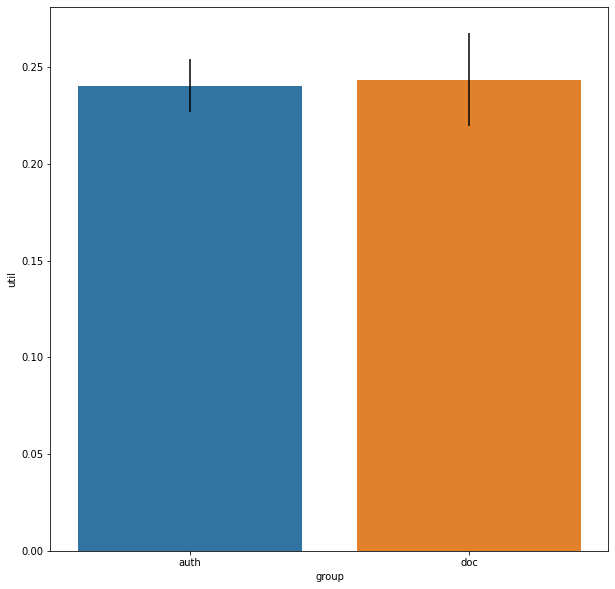

In [115]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('group')
means = groups['util'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='util',ci=None, yerr=[c1,c2], data=meta99,ax=axs)


<AxesSubplot:xlabel='hfunc', ylabel='util'>

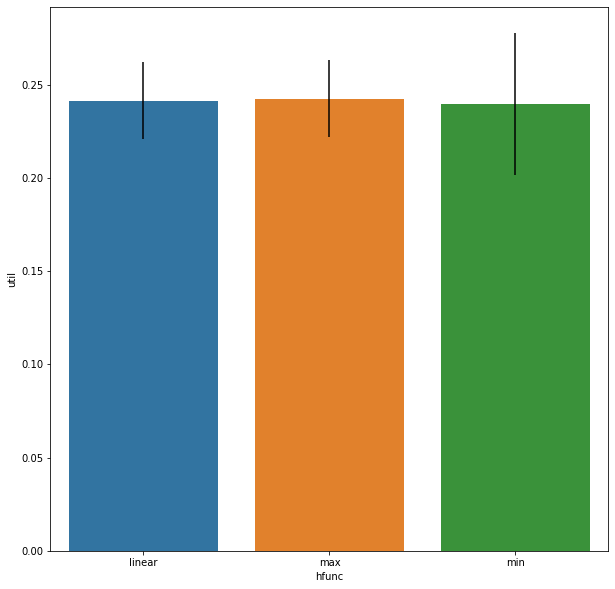

In [116]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('hfunc')
means = groups['util'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,1,figsize=(10,10))

sns.barplot(x='hfunc', y='util',ci=None, yerr=[c1,c2,c3], data=meta99,ax=axs)


#### text9

In [117]:
formula = "util ~ C(group) + C(hfunc)"
lm = ols(formula, text9).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   util   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                   0.01482
Date:                Thu, 02 Jun 2022   Prob (F-statistic):              0.998
Time:                        12:04:09   Log-Likelihood:                 205.99
No. Observations:                 240   AIC:                            -404.0
Df Residuals:                     236   BIC:                            -390.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2308      0.012     18.934      0.000       0.207       0.255
C(group)[T.doc]     0.0029      0.015      0.191      0.849      -0.027       0.033
C(hfunc)[T.max]  5.458e-05      0.016      0.003      0.997      -0.032       0.032
C(hfunc)[T.min]     0.0013      0.016      0.080      0.936      -0.031       0.034
==============================================================================
Omnibus:                       40.266   Durbin-Watson:                   2.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.233
Skew:                           1.050   Prob(JB):                     6.15e-13
Kurtosis:                       4.103   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

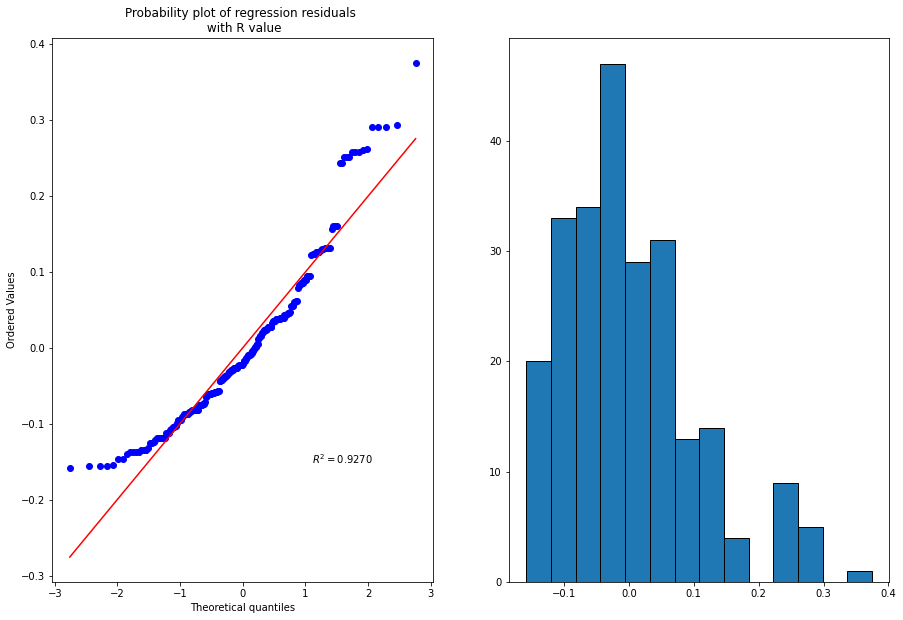

In [118]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [119]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.000388,0.000388,0.036308,0.849045
C(hfunc),2.0,0.000087,0.000044,0.004072,0.995936
Residual,236.0,2.524813,0.010698,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='util'>

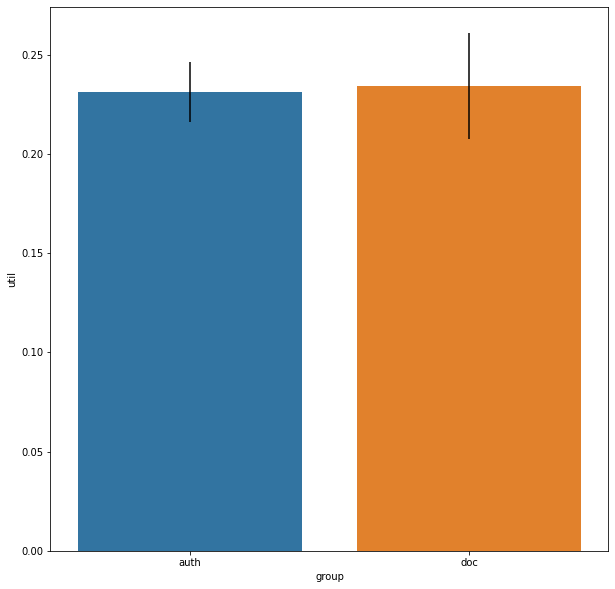

In [120]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('group')
means = groups['util'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='util',ci=None, yerr=[c1,c2], data=text9,ax=axs)


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

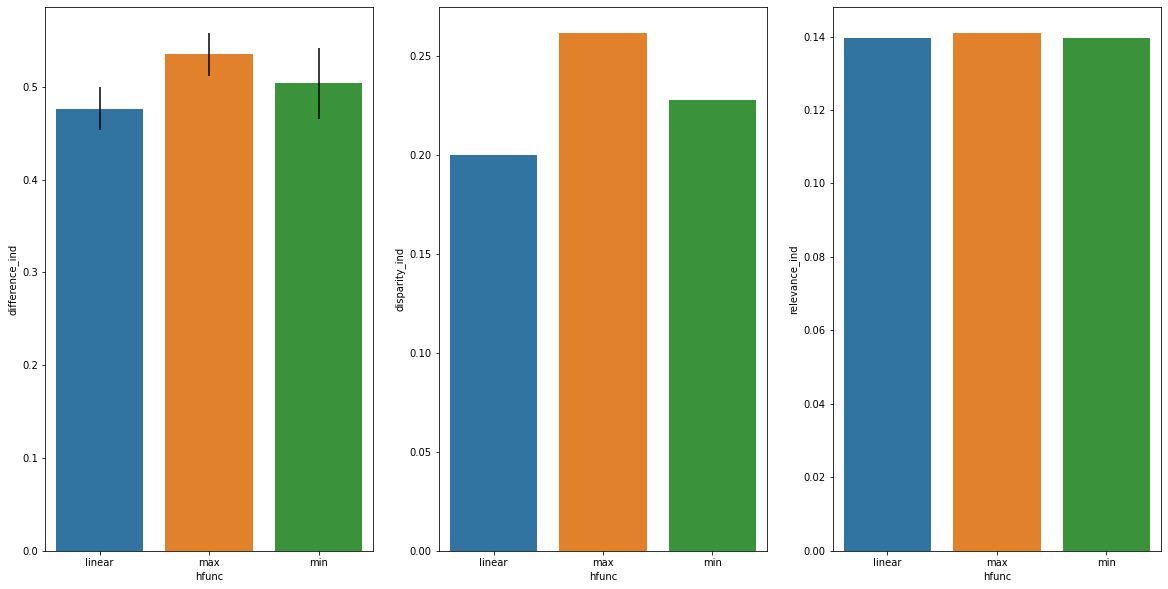

In [121]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=text9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=text9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=text9, ax=axs[2])

#### text99

In [122]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, text99).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.07165
Date:                Thu, 02 Jun 2022   Prob (F-statistic):              0.975
Time:                        12:04:11   Log-Likelihood:                -201.76
No. Observations:                 240   AIC:                             411.5
Df Residuals:                     236   BIC:                             425.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4620      0.067      6.931      0.000       0.331       0.593
C(group)[T.doc]    -0.0344      0.084     -0.408      0.684      -0.201       0.132
C(hfunc)[T.max]    -0.0036      0.089     -0.040      0.968      -0.180       0.173
C(hfunc)[T.min]     0.0150      0.089      0.168      0.867      -0.161       0.191
==============================================================================
Omnibus:                      130.265   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              517.305
Skew:                           2.365   Prob(JB):                    4.66e-113
Kurtosis:                       8.418   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

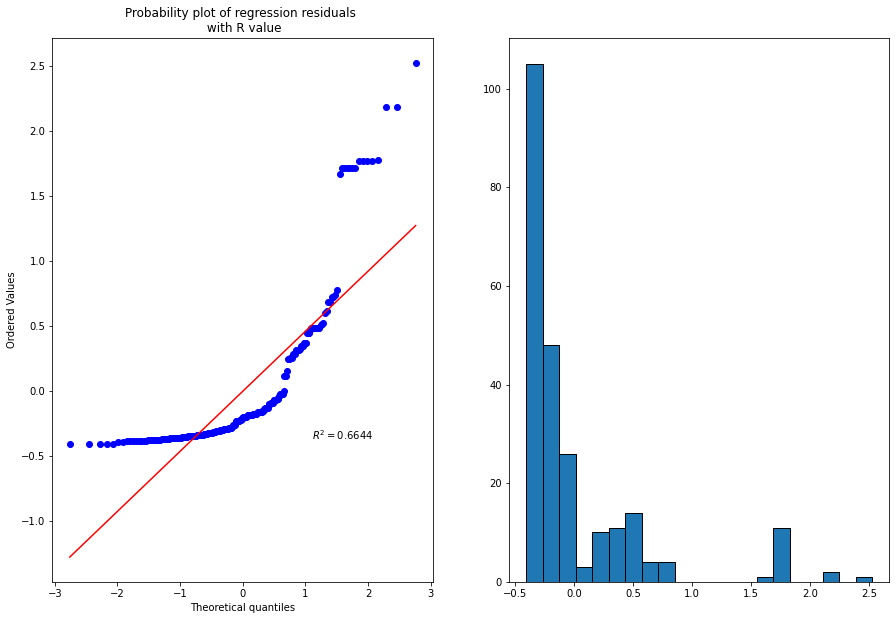

In [123]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf


fig = plt.figure(figsize= (15, 10))
ax = fig.add_subplot(121)


normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

ax2 = fig.add_subplot(122)
plt.hist(lm.resid, bins='auto', histtype='bar', ec='k') 

plt.show()

In [124]:
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.053267,0.053267,0.166510,0.683602
C(hfunc),2.0,0.015499,0.007749,0.024225,0.976069
Residual,236.0,75.496408,0.319900,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='util'>

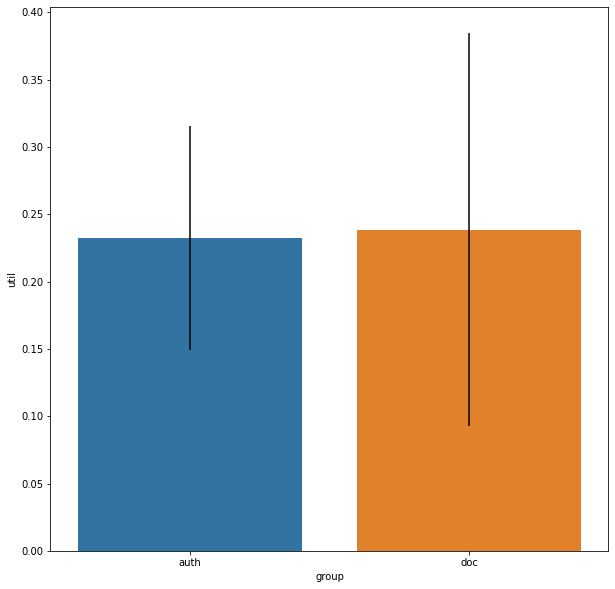

In [125]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('group')
means = groups['util'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,1,figsize=(10,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='util',ci=None, yerr=[c1,c2], data=text99,ax=axs)


<AxesSubplot:xlabel='hfunc', ylabel='util'>

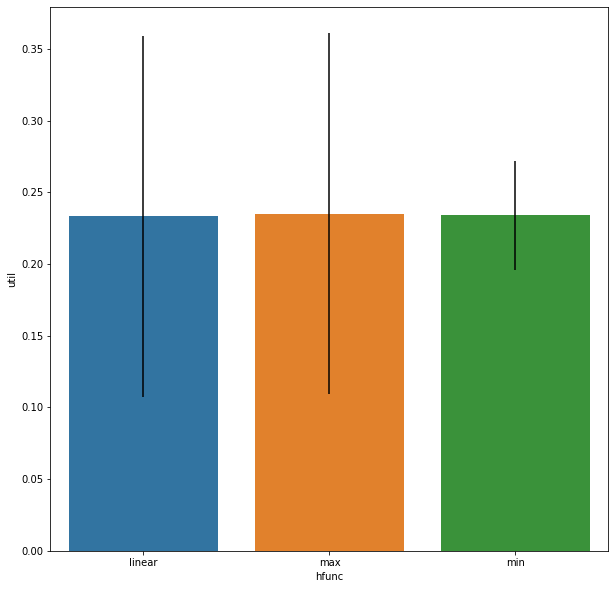

In [126]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('hfunc')
means = groups['util'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,1,figsize=(10,10))

sns.barplot(x='hfunc', y='util',ci=None, yerr=[c1,c2,c3], data=text99,ax=axs)


## Which pipeline configuration yields the best result? Which factors make it so?

Since the base LM config (NDCG, no augmentation, no feature selection) yields the highest fairness both for group and individual fairness, we use it as the base configuration for re-ranking.

Now we see if re-ranking significantly improves the eel and eel ind.

### ANOVA without replication main factors

In [276]:
pipeline = experiments
# pipeline = experiments[((experiments.ranker == 'ac') | (experiments.ranker == 'rfr') | (experiments.ranker == 'lambdamart'))]
pipeline.source = pipeline.source.apply(lambda row: 'lm_err' if 'err' in row else 'lm_ndcg' if 'ndcg' in row else row)
pipeline = pipeline.reset_index(drop=True)

for col in ['ranker','qid','source','group', 'subgroup', 'theta', 'hfunc', 'augmentation','val_metric','feature_method']:
    print(col,'\t', Counter(pipeline[col]))

pipeline

ranker 	 Counter({'ac': 55680, 'rfr': 9280, 'lambdamart': 2280, 'relevance_ranker': 40})
qid 	 Counter({3462: 3364, 8940: 3364, 10795: 3364, 12073: 3364, 12096: 3364, 12828: 3364, 20363: 3364, 25869: 3364, 27887: 3364, 30631: 3364, 31412: 3364, 43018: 3364, 49766: 3364, 51432: 3364, 54003: 3364, 64062: 3364, 66637: 3364, 67404: 3364, 70673: 3364, 120668: 3364})
source 	 Counter({'lm_err': 31920, 'lm_ndcg': 31920, '-': 2280, 'META_train': 580, 'TEXT_train': 580})
group 	 Counter({'auth': 48720, 'doc': 16240, '-': 2320})
subgroup 	 Counter({'-': 18560, 'ind': 16240, 'one': 16240, 'none': 16200, 'ignore': 40})
theta 	 Counter({99.0: 27840, 9.0: 27840, '-': 11600})
hfunc 	 Counter({'linear': 18560, 'max': 18560, 'min': 18560, '-': 11600})
augmentation 	 Counter({'-': 65760, 'aug0.5': 760, 'aug0.7': 760})
val_metric 	 Counter({'-': 65000, 'err': 1140, 'ndcg': 1140})
feature_method 	 Counter({'-': 65120, 'mpt': 1080, 'msd': 1080})


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-


## group EEL

In [277]:
formula = "difference ~ C(ranker) + C(qid)"
lm = ols(formula, pipeline).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),3.00000,434.80391,144.93464,2789.92696,0.00000
C(qid),19.00000,13105.33450,689.75445,13277.46468,0.00000
Residual,67257.00000,3493.95129,0.05195,NaN,NaN


#### ANOVA effect sizes

In [278]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.02553			0.11067



#### Tukey HSD

In [279]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
              ac       lambdamart    0.435 0.001  0.4077  0.4623   True
              ac relevance_ranker   0.4812 0.001  0.2794  0.6831   True
              ac              rfr   0.0557 0.001  0.0414    0.07   True
      lambdamart relevance_ranker   0.0462   0.9 -0.1573  0.2498  False
      lambdamart              rfr  -0.3793 0.001 -0.4091 -0.3494   True
relevance_ranker              rfr  -0.4255 0.001 -0.6277 -0.2233   True
-----------------------------------------------------------------------


#### cohen's d

In [280]:
pipeline.groupby('ranker')['difference'].mean()

ranker
ac                 0.44073
lambdamart         0.87573
relevance_ranker   0.92196
rfr                0.49646
Name: difference, dtype: float64

In [281]:
# val_metric
means = pipeline.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['ac']
m3 = means['rfr']
m4 = means['relevance_ranker']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

1.9085232792321973
1.6639966934689998
0.20284396589698817
0.24452658576319752
2.1113672451291854
1.866840659365988


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [282]:
pipeline.groupby('ranker')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
ranker,,,
ac,0.44073,1.60227,1.12737
lambdamart,0.87573,2.13876,1.17812
relevance_ranker,0.92196,2.09242,1.13183
rfr,0.49646,1.69285,1.14479


<AxesSubplot:xlabel='ranker', ylabel='relevance'>

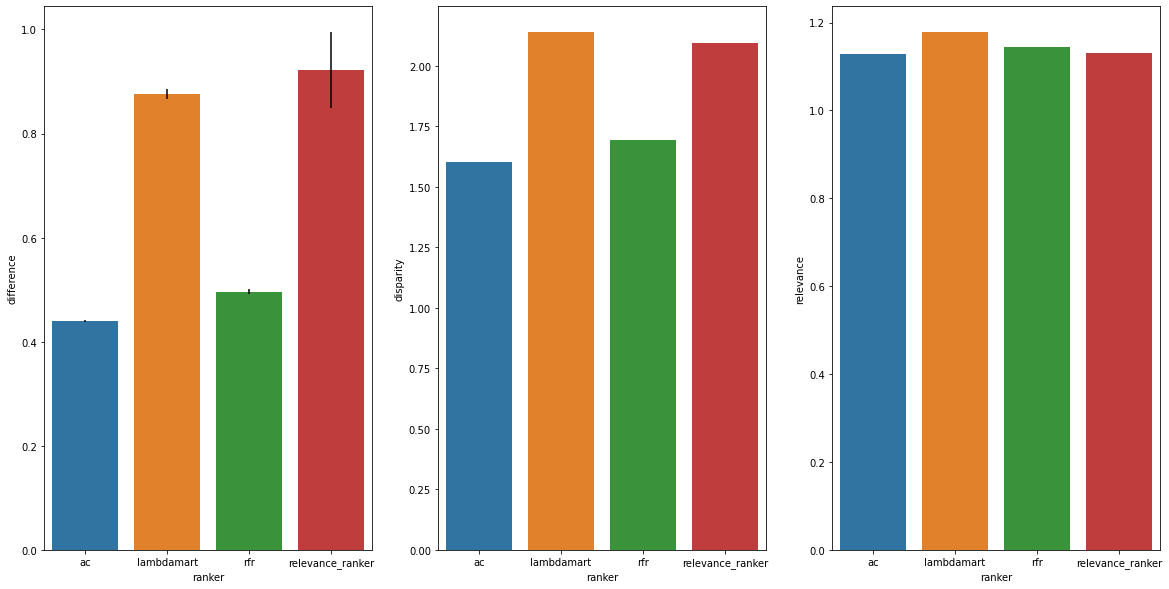

In [283]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = pipeline.groupby('ranker')
means = groups['difference'].mean()
m1 = means['ac']
n1 = len(groups.get_group('ac'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))
m3 = means['rfr']
n3 = len(groups.get_group('rfr'))
m4 = means['relevance_ranker']
n4 = len(groups.get_group('relevance_ranker'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=pipeline,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=pipeline, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=pipeline, ax=axs[2])


## within AC and RFR

#### AC

In [299]:
experiments.drop_duplicates()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-


In [306]:
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-


In [305]:
experiments[experiments.duplicated(keep=False)].sort_values(by='difference')

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
21705,0.04734,1.28346,1.08220,0.42881,0.30773,0.33086,0.34603,12828,ac,lm_err,auth,ind,9.00000,min,-,-,-,-,-
22065,0.04734,1.28346,1.08220,0.42881,0.30773,0.33086,0.34603,12828,ac,lm_err,doc,-,9.00000,min,-,-,-,-,-
22185,0.04734,1.28346,1.08220,0.42881,0.30773,0.33086,0.34603,12828,ac,lm_err,auth,ind,9.00000,min,-,-,-,-,-
22545,0.04734,1.28346,1.08220,0.42881,0.30773,0.33086,0.34603,12828,ac,lm_err,doc,-,9.00000,min,-,-,-,-,-
21945,0.04734,1.28346,1.08220,0.42881,0.30773,0.33086,0.34603,12828,ac,lm_err,auth,one,9.00000,min,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60150,3.33089,2.50415,0.38121,1.06391,0.43631,0.07728,0.07133,31412,rfr,lm_err,auth,none,-,-,-,-,-,-,-
60050,3.33089,2.50416,0.38121,1.06391,0.43631,0.07728,0.07133,31412,rfr,lm_err,auth,ind,-,-,-,-,-,-,-
60090,3.33089,2.50416,0.38121,1.06391,0.43631,0.07728,0.07133,31412,rfr,lm_err,auth,one,-,-,-,-,-,-,-
60130,3.33089,2.50416,0.38121,1.06391,0.43631,0.07728,0.07133,31412,rfr,lm_err,auth,ind,-,-,-,-,-,-,-


In [297]:
pipeline

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-


In [284]:
acdata = pipeline[(pipeline.ranker == 'ac')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)
acdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55675,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,0.27100,64062,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55676,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,0.25412,66637,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55677,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,0.26757,67404,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55678,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,0.15994,70673,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-


In [289]:
formula = 'difference ~ C(group) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,2.47401,2.47401,89.09312,0.00000
C(theta),1.00000,0.09898,0.09898,3.56445,0.05903
C(hfunc),2.00000,2.49053,1.24527,44.84403,0.00000
C(source),3.00000,0.88432,0.29477,10.61525,0.00000
C(qid),19.00000,9903.26710,521.22458,18770.11906,0.00000
Residual,55653.00000,1545.41970,0.02777,NaN,NaN


#### ANOVA effect sizes

In [286]:
print_etasq('group')
print_etasq('hfunc')
print_etasq('source')

group
eta-squared	eta-squared partial
0.00022			0.0016

hfunc
eta-squared	eta-squared partial
0.00022			0.00161

source
eta-squared	eta-squared partial
8e-05			0.00057



#### Tukey HSD

In [287]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['group'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  auth    doc  -0.0154 0.001 -0.0241 -0.0067   True
---------------------------------------------------


In [288]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['source'], alpha=0.05)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
META_train TEXT_train   0.0169    0.9 -0.0583 0.0921  False
META_train     lm_err  -0.0042    0.9 -0.0579 0.0494  False
META_train    lm_ndcg  -0.0107    0.9 -0.0644 0.0429  False
TEXT_train     lm_err  -0.0211 0.7175 -0.0748 0.0325  False
TEXT_train    lm_ndcg  -0.0276  0.543 -0.0813  0.026  False
    lm_err    lm_ndcg  -0.0065 0.3376 -0.0165 0.0035  False
-----------------------------------------------------------


#### cohen's d

In [290]:
# val_metric
means = acdata.groupby('group')['difference'].mean()
m1 = means['auth']
m2 = means['doc']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.09237869708194096


In [296]:
acdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55675,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,0.27100,64062,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55676,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,0.25412,66637,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55677,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,0.26757,67404,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55678,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,0.15994,70673,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-


In [295]:
acdata.drop_duplicates()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55675,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,0.27100,64062,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55676,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,0.25412,66637,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55677,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,0.26757,67404,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-
55678,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,0.15994,70673,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-


In [293]:
means

source
META_train   0.44795
TEXT_train   0.46482
lm_err       0.44370
lm_ndcg      0.43721
Name: difference, dtype: float64

In [292]:
# val_metric
means = acdata.groupby('source')['difference'].mean()
m1 = means['lm_err']
m2 = means['lm_ndcg']
m3 = means['META_train']
m4 = means['TEXT_train']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))



0.038959156675912134
0.038959156675912134
0.025471726321062867
0.12674641850044988
0.064430882996975
0.165705575176362
0.101274692179387


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

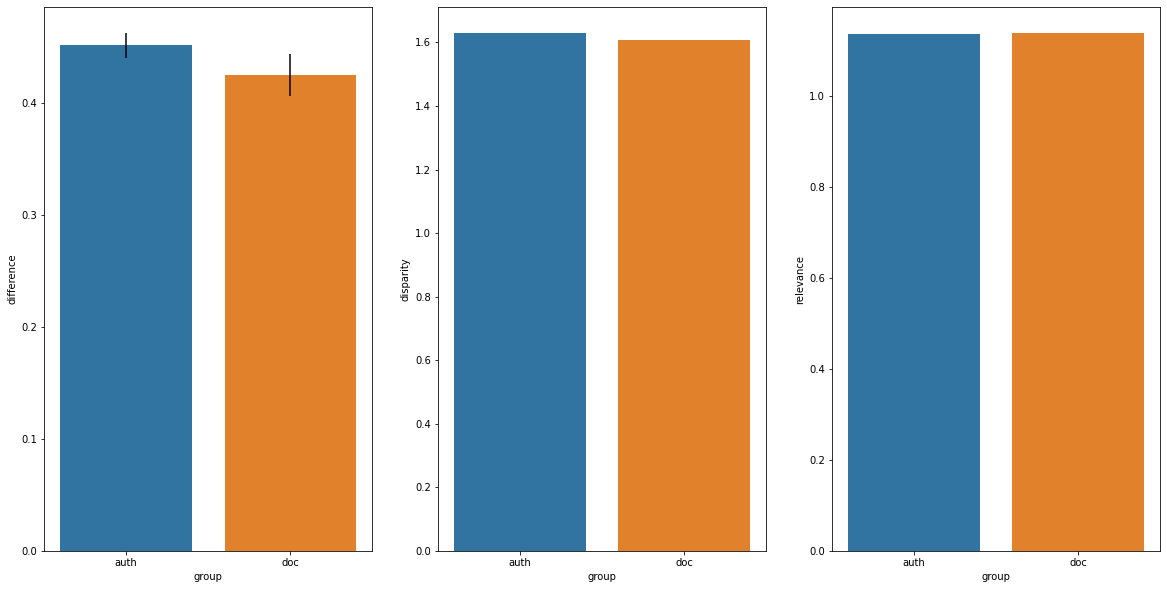

In [240]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=acdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance'>

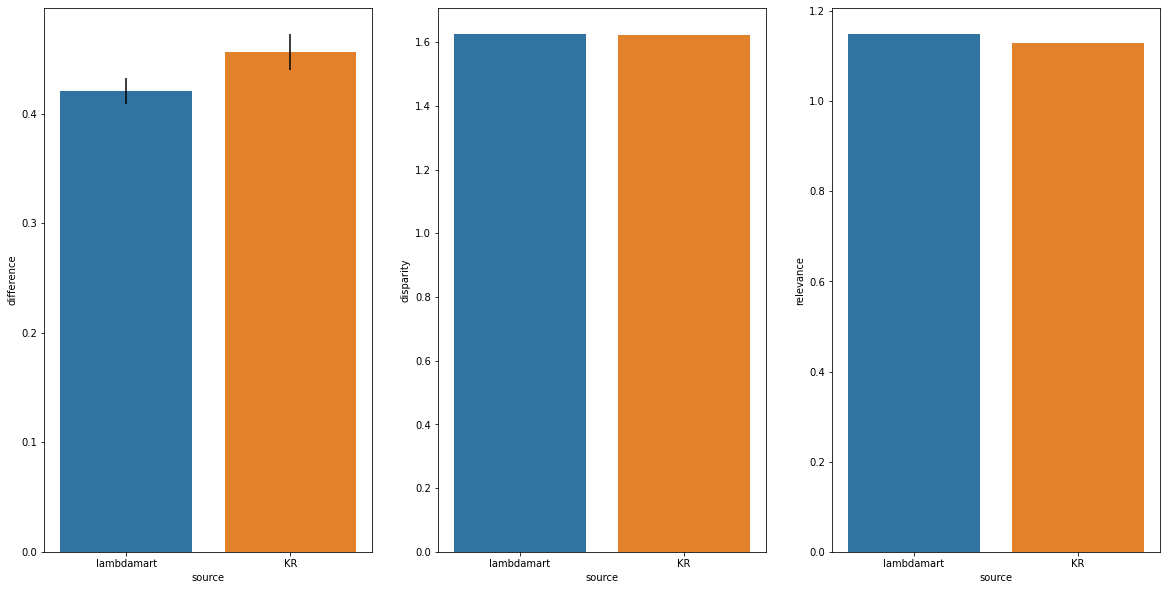

In [241]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('source')
means = groups['difference'].mean()
m1 = means['KR']
n1 = len(groups.get_group('KR'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='source', y='disparity', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='source', y='relevance', ci=None, data=acdata, ax=axs[2])


## RFR

In [242]:
rfrdata = pipeline[(pipeline.ranker == 'rfr')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)
rfrdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.585954,2.667452,1.597434,0.765604,0.329808,0.002592,0.004371,3462,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
1,0.535829,1.435822,0.895581,0.664201,0.393011,0.255895,0.254393,8940,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
2,0.232734,1.960922,1.468794,0.408923,0.186342,0.066140,0.171562,10795,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
3,0.167104,1.216175,0.855114,0.174013,0.114502,0.051053,0.288232,12073,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
4,0.143050,1.779963,1.684735,1.099414,0.423035,0.052847,0.044711,12096,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.402150,2.441503,1.577406,0.374586,0.257188,0.161792,0.322741,64062,rfr,KR,doc,-,-,-,-,-,-,-,-
236,0.150777,3.059053,2.380250,0.609978,0.483562,0.328282,0.330261,66637,rfr,KR,doc,-,-,-,-,-,-,-,-
237,0.050436,1.884897,1.770575,0.495148,0.495443,0.391637,0.411824,67404,rfr,KR,doc,-,-,-,-,-,-,-,-
238,0.251974,1.613103,1.143375,0.819353,0.290380,0.126659,0.121662,70673,rfr,KR,doc,-,-,-,-,-,-,-,-


In [246]:
formula = 'difference ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.578517,0.578517,5.396949,2.109365e-02
C(source),1.0,0.424317,0.424317,3.958423,4.788719e-02
C(qid),19.0,163.493647,8.604929,80.274835,3.119562e-87
Residual,218.0,23.368151,0.107193,NaN,NaN


#### ANOVA effect sizes

In [247]:
df_effect = anova_lm(lm).df.loc['C(group)']
ms_effect = anova_lm(lm).mean_sq.loc['C(group)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(rfrdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.0025102799319983954
0.01839727688194295


In [248]:
df_effect = anova_lm(lm).df.loc['C(source)']
ms_effect = anova_lm(lm).mean_sq.loc['C(source)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(rfrdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))

print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.0016890053329117235
0.012378340108036632


#### Tukey HSD

In [249]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference'], groups=rfrdata['group'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  auth    doc  -0.1134 0.3921 -0.3739 0.1471  False
---------------------------------------------------


In [250]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference'], groups=rfrdata['source'], alpha=0.05)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    KR lambdamart  -0.0892 0.4637 -0.3286 0.1502  False
-------------------------------------------------------


#### cohen's d

In [251]:
# val_metric
means = rfrdata.groupby('group')['difference'].mean()
m1 = means['auth']
m2 = means['doc']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.34631229242418915


In [252]:
# val_metric
means = rfrdata.groupby('source')['difference'].mean()
m1 = means['lambdamart']
m2 = means['KR']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.27243427943109216


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

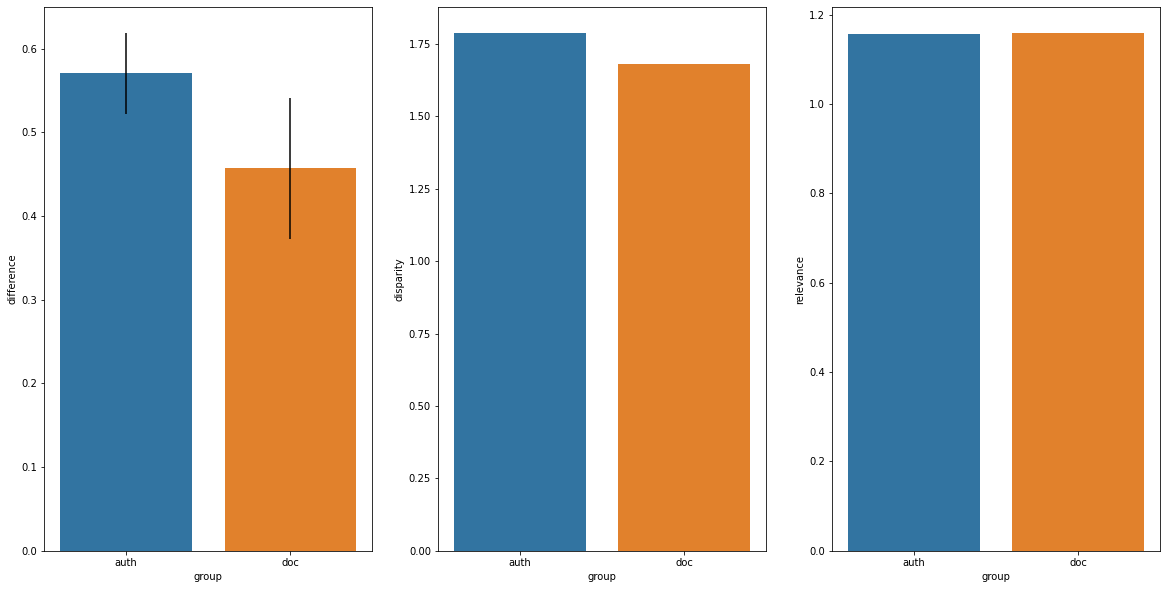

In [253]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=rfrdata,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=rfrdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance'>

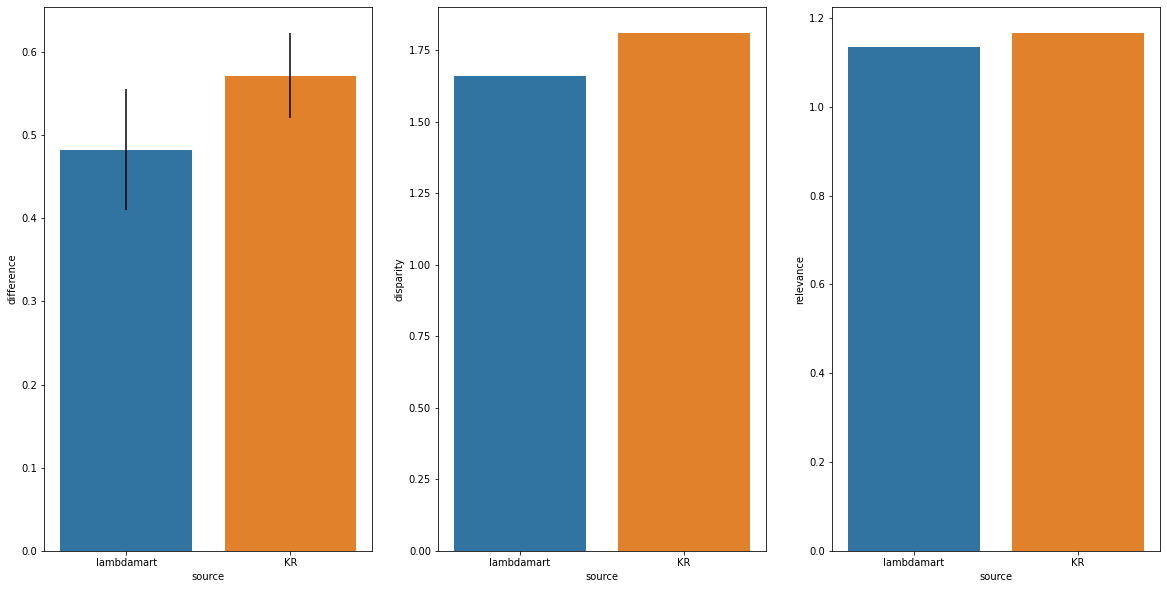

In [255]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('source')
means = groups['difference'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['KR']
n2 = len(groups.get_group('KR'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',ci=None, yerr=[c1,c2], data=rfrdata,ax=axs[0])
sns.barplot(x='source', y='disparity', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='source', y='relevance', ci=None, data=rfrdata, ax=axs[2])


## ind EEL

In [256]:
formula = "difference_ind ~ C(ranker) + C(qid)"
lm = ols(formula, pipeline).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),2.0,21.891449,10.945725,407.522043,5.546465e-145
C(qid),19.0,88.666245,4.666644,173.744594,0.000000e+00
Residual,1678.0,45.069773,0.026859,NaN,NaN


#### ANOVA effect sizes

In [257]:
df_effect = anova_lm(lm).df.loc['C(ranker)']
ms_effect = anova_lm(lm).mean_sq.loc['C(ranker)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(pipeline)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.14034476595123915
0.4788245503133888


#### Tukey HSD

In [258]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference_ind'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
        ac lambdamart    0.892 0.001  0.7438  1.0403   True
        ac        rfr   0.1856 0.001  0.1397  0.2315   True
lambdamart        rfr  -0.7065 0.001 -0.8597 -0.5532   True
-----------------------------------------------------------


#### cohen's d

In [259]:
# val_metric
means = pipeline.groupby('ranker')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['ac']
m3 = means['rfr']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


5.443004288176515
4.310639115898937
1.1323651722775774


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [260]:
pipeline.groupby('ranker')[['difference_ind','disparity_ind','relevance_ind']].mean()

,difference_ind,disparity_ind,relevance_ind
ranker,,,
ac,0.485732,0.234439,0.152026
lambdamart,1.377774,1.239142,0.208356
rfr,0.671313,0.420061,0.152047


<AxesSubplot:xlabel='ranker', ylabel='relevance_ind'>

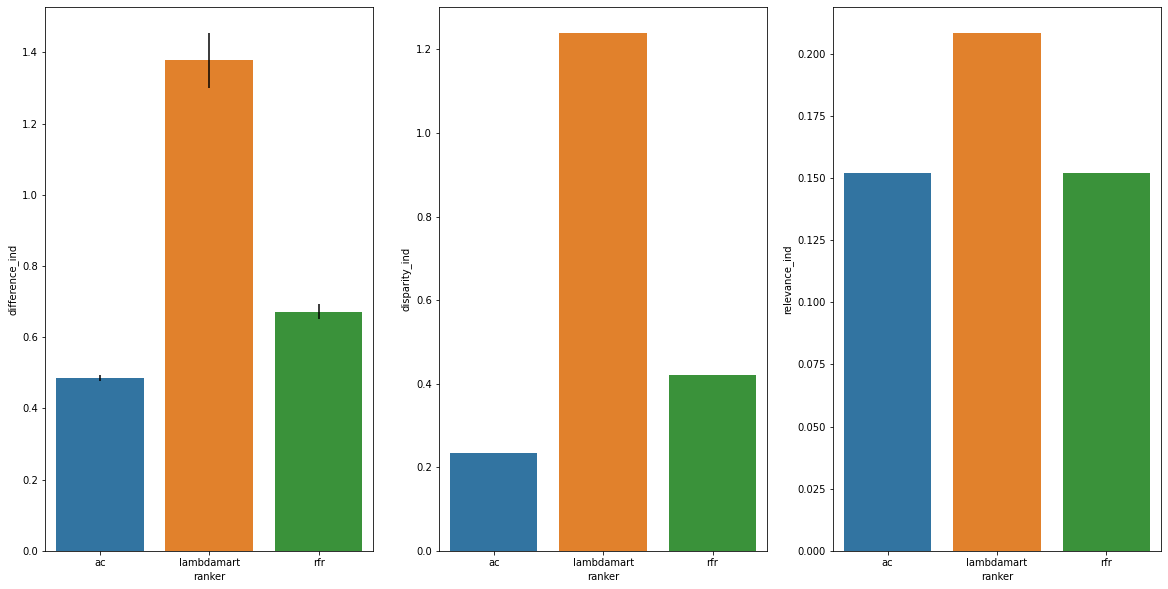

In [261]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = pipeline.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['ac']
n1 = len(groups.get_group('ac'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))
m3 = means['rfr']
n3 = len(groups.get_group('rfr'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=pipeline,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=pipeline, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=pipeline, ax=axs[2])


## within AC and RFR

#### AC

In [262]:
acdata = pipeline[(pipeline.ranker == 'ac')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)
acdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.182191,1.980651,1.455915,0.437331,0.170282,0.086966,0.179057,3462,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
1,1.041090,2.171230,1.010655,0.816026,0.448635,0.207794,0.206360,8940,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
2,0.414444,1.583612,1.189284,0.454495,0.250329,0.075348,0.195310,10795,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
3,0.039438,0.827501,0.724610,0.108136,0.129017,0.091249,0.496302,12073,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
4,0.299488,1.349268,1.391169,0.853557,0.352509,0.140512,0.144921,12096,ac,lambdamart,auth,ind,99.0,linear,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.272667,2.230380,1.536586,0.343055,0.168404,0.133166,0.271003,64062,ac,KR,doc,-,9.0,min,-,-,-,-,-
1436,0.114067,2.821265,2.279711,0.588711,0.307959,0.251114,0.254121,66637,ac,KR,doc,-,9.0,min,-,-,-,-,-
1437,0.306071,1.413757,1.407188,0.562221,0.303359,0.262059,0.267570,67404,ac,KR,doc,-,9.0,min,-,-,-,-,-
1438,0.443033,1.829159,1.155873,0.680858,0.214499,0.157966,0.159937,70673,ac,KR,doc,-,9.0,min,-,-,-,-,-


In [263]:
formula = 'difference_ind ~ C(group) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.240185,0.240185,20.777703,0.000006
C(theta),1.0,0.018863,0.018863,1.631757,0.201670
C(hfunc),2.0,0.245138,0.122569,10.603121,0.000027
C(source),1.0,0.027428,0.027428,2.372684,0.123698
C(qid),19.0,68.078024,3.583054,309.960156,0.000000
Residual,1415.0,16.357010,0.011560,NaN,NaN


#### ANOVA effect sizes

In [264]:
df_effect = anova_lm(lm).df.loc['C(group)']
ms_effect = anova_lm(lm).mean_sq.loc['C(group)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(acdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.0026911253608688495
0.013744060352410157


In [265]:
df_effect = anova_lm(lm).df.loc['C(source)']
ms_effect = anova_lm(lm).mean_sq.loc['C(source)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(acdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.00018677925327426382
0.0009539151787231405


#### Tukey HSD

In [266]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['group'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  auth    doc  -0.0298 0.0437 -0.0588 -0.0008   True
----------------------------------------------------


In [267]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['source'], alpha=0.05)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    KR lambdamart  -0.0093 0.4957 -0.0359 0.0174  False
-------------------------------------------------------


#### cohen's d

In [268]:
# val_metric
means = acdata.groupby('group')['difference_ind'].mean()
m1 = means['auth']
m2 = means['doc']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.2774066599584933


In [269]:
# val_metric
means = acdata.groupby('source')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['KR']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.08610828833116844


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

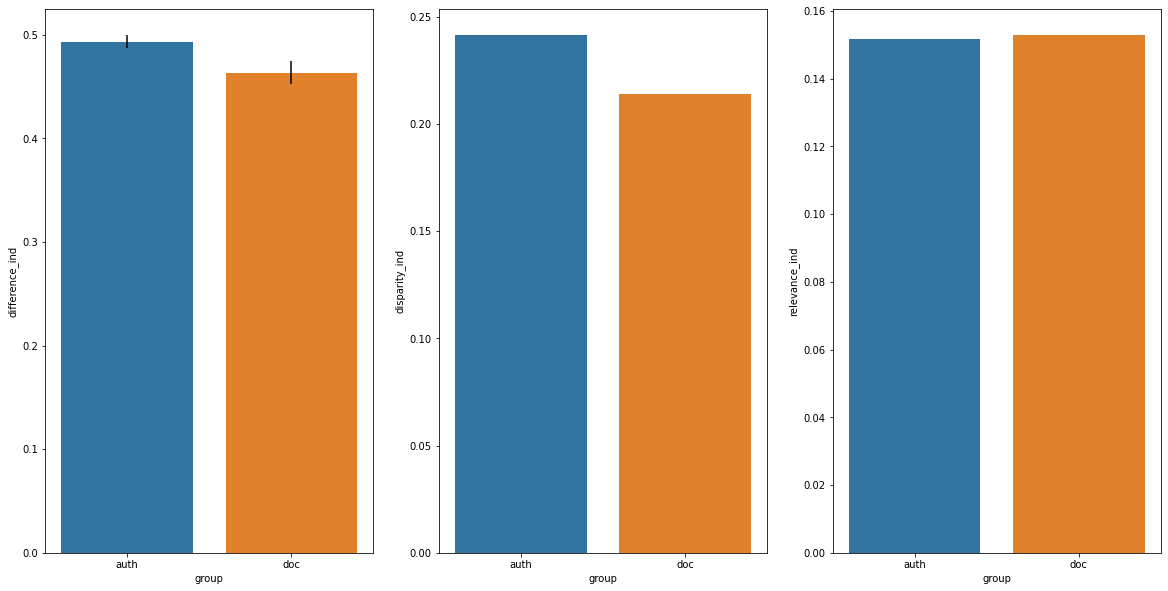

In [270]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance'>

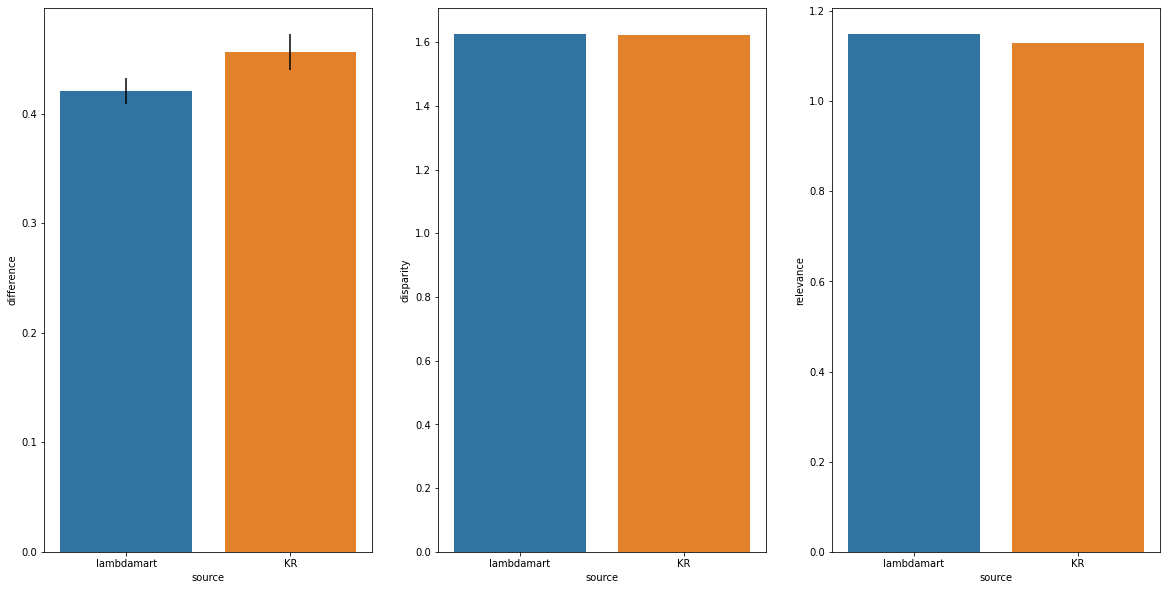

In [241]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('source')
means = groups['difference_ind'].mean()
m1 = means['KR']
n1 = len(groups.get_group('KR'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='source', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='source', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


## RFR

In [271]:
rfrdata = pipeline[(pipeline.ranker == 'rfr')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)
rfrdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor
0,0.585954,2.667452,1.597434,0.765604,0.329808,0.002592,0.004371,3462,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
1,0.535829,1.435822,0.895581,0.664201,0.393011,0.255895,0.254393,8940,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
2,0.232734,1.960922,1.468794,0.408923,0.186342,0.066140,0.171562,10795,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
3,0.167104,1.216175,0.855114,0.174013,0.114502,0.051053,0.288232,12073,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
4,0.143050,1.779963,1.684735,1.099414,0.423035,0.052847,0.044711,12096,rfr,lambdamart,auth,ind,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.402150,2.441503,1.577406,0.374586,0.257188,0.161792,0.322741,64062,rfr,KR,doc,-,-,-,-,-,-,-,-
236,0.150777,3.059053,2.380250,0.609978,0.483562,0.328282,0.330261,66637,rfr,KR,doc,-,-,-,-,-,-,-,-
237,0.050436,1.884897,1.770575,0.495148,0.495443,0.391637,0.411824,67404,rfr,KR,doc,-,-,-,-,-,-,-,-
238,0.251974,1.613103,1.143375,0.819353,0.290380,0.126659,0.121662,70673,rfr,KR,doc,-,-,-,-,-,-,-,-


In [272]:
formula = 'difference_ind ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,2.363998,2.363998,68.189929,1.425661e-14
C(source),1.0,2.191441,2.191441,63.212492,9.925514e-14
C(qid),19.0,31.144852,1.639203,47.283089,1.925904e-66
Residual,218.0,7.557590,0.034668,NaN,NaN


#### ANOVA effect sizes

In [273]:
df_effect = anova_lm(lm).df.loc['C(group)']
ms_effect = anova_lm(lm).mean_sq.loc['C(group)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(rfrdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))
print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.05389071726587675
0.2811294088883842


In [274]:
df_effect = anova_lm(lm).df.loc['C(source)']
ms_effect = anova_lm(lm).mean_sq.loc['C(source)']
ms_error = anova_lm(lm).mean_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()
total_obs = len(rfrdata)
print(omega_squared(ms_effect, ms_error, df_effect, ss_total))

print(omega_squared_partial(ms_effect, ms_error, df_effect, total_obs))

0.049898487165952875
0.26030331220459285


#### Tukey HSD

In [275]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['group'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  auth    doc  -0.2292 0.001 -0.3509 -0.1075   True
---------------------------------------------------


In [276]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['source'], alpha=0.05)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------
    KR lambdamart  -0.2027 0.001 -0.3148 -0.0907   True
-------------------------------------------------------


#### cohen's d

In [277]:
# val_metric
means = rfrdata.groupby('group')['difference_ind'].mean()
m1 = means['auth']
m2 = means['doc']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


1.2309881191260206


In [278]:
# val_metric
means = rfrdata.groupby('source')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['KR']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


1.0886846273447723


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

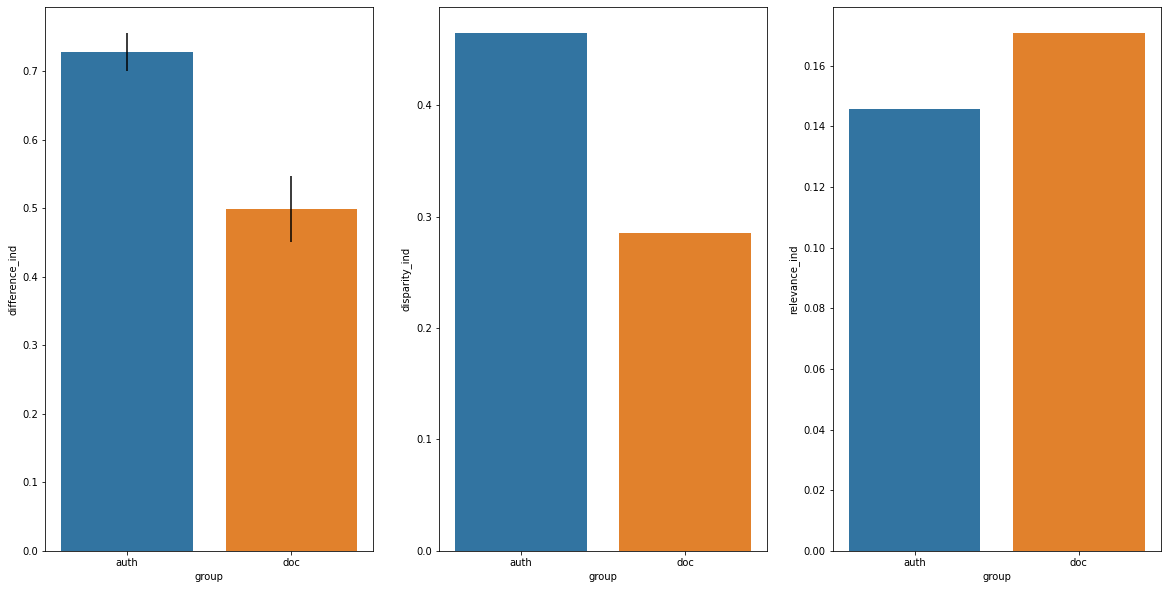

In [279]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=rfrdata,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=rfrdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance_ind'>

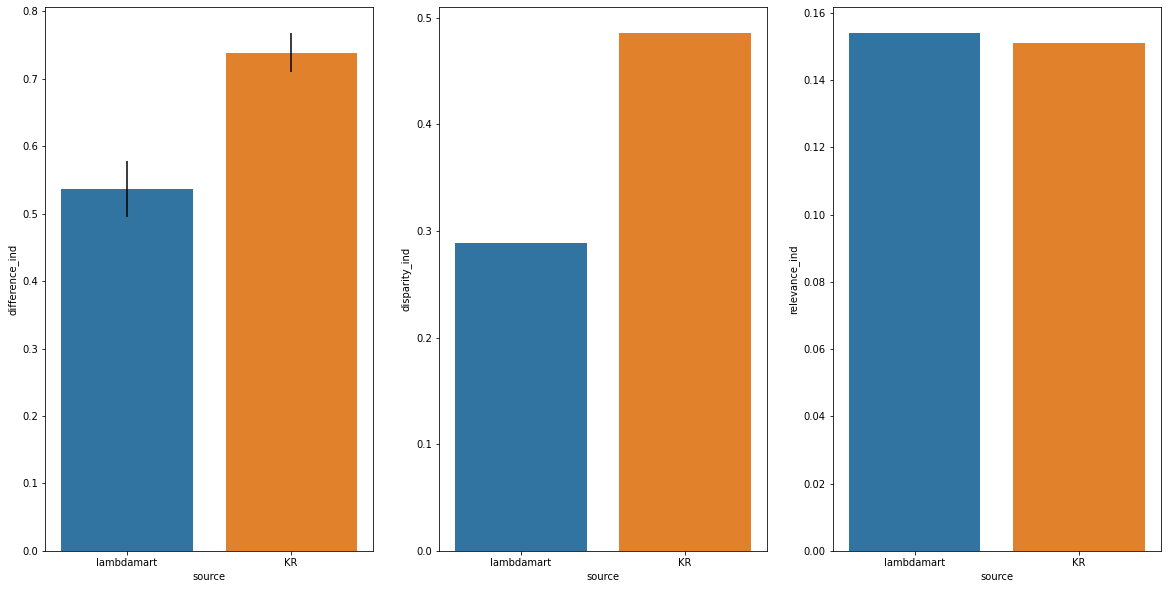

In [280]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('source')
means = groups['difference_ind'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['KR']
n2 = len(groups.get_group('KR'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',ci=None, yerr=[c1,c2], data=rfrdata,ax=axs[0])
sns.barplot(x='source', y='disparity_ind', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='source', y='relevance_ind', ci=None, data=rfrdata, ax=axs[2])
